In [ ]:
# This script is just used to test the convolution operation, ignore it.









import numpy as np
from scipy.signal import convolve2d

# Define the 2D matrix
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Define the 2D kernel
K = np.array([[0, 1, 0],
              [1, -4, 1],
              [0, 1, 0]])

# Pad the array to simulate periodic boundaries
pad_width = (len(K) - 1) // 2
A_padded = np.pad(A, pad_width, mode='wrap')

# Perform the convolution
result = convolve2d(A_padded, K, mode='valid')

# Crop to the original size
result = result[:A.shape[0], :A.shape[1]]
print(result)


[[ 12   9   6]
 [  3   0  -3]
 [ -6  -9 -12]]


In [10]:
print(pad_width)
A_padded = np.pad(A, pad_width+1, mode='wrap')
print(A_padded)
print(convolve2d(A_padded, K, mode='valid'))

1
[[5 6 4 5 6 4 5]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [5 6 4 5 6 4 5]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [5 6 4 5 6 4 5]]
[[-12  -6  -9 -12  -6]
 [  6  12   9   6  12]
 [ -3   3   0  -3   3]
 [-12  -6  -9 -12  -6]
 [  6  12   9   6  12]]


In [1]:
import torch
import torch.nn.functional as F

def dynamic_conv2d(input_tensor, kernel_generator):
    # 动态生成卷积核
    dynamic_kernel = kernel_generator(input_tensor)
    # 应用动态卷积核
    output = F.conv2d(input_tensor, dynamic_kernel, padding=1)
    return output


In [10]:
import torch
import torch.nn.functional as F
import numpy as np

def target_age_coe(target_age, kernel_size):
    # target_age: torch.tensor, shape [1, 1, N*N]
    # return a tensor R_tensor with shape [1, kernel_size*kernel_size, N*N], where for each i in range(kernel_size),
    # R_tensor[0, 0, i, :] = target_age[0, 0, 0, :]
    # age_coe = balabalabala...
    age_coe = torch.rand_like(target_age)
    R_tensor = torch.zeros(1,kernel_size*kernel_size , target_age.shape[2])
    for i in range(target_age.shape[2]):
        R_tensor[0, :, i] = age_coe[0, 0, i].item()
    return R_tensor

# test = np.random.rand(1, 1, 10)
# test = torch.tensor(test).float()

# result_numpy = target_age_coe(test, 3).numpy()
# print(result_numpy.shape)
# print(result_numpy[:, :, 0:3])


def distance_coe(distance_kernel, data_shape):
    # distance_kernel: torch.tensor, shape [kernel_size, kernel_size]
    # data_shape: tuple, [1, kernel_size*kernel_size, N*N]
    # flat the distance_kernel to a 1D tensor with shape [kernel_size * kernel_size, 1]
    flatted_distance_kernel = distance_kernel.view(-1, 1)
    print(distance_kernel)
    print(flatted_distance_kernel)
    # return a tensor R_tensor with shape [1, 1, kernel_size*kernel_size, N*],
    #  where for each j in range(N*N),
    # R_tensor[0, 0, :, j] = flatted_distance_kernel
    R_tensor = torch.zeros(data_shape)
    # row = torch.ones(1, data_shape[2])
    for i in range(data_shape[1]):
        R_tensor[0, i, :] = flatted_distance_kernel[i, 0].item()
    return R_tensor



    # R_tensor = torch.zeros(data_shape)
    # for j in range(data_shape[3]):
    #     R_tensor[0, :, j] = flatted_distance_kernel[:, 0]

#test for distance_coe
# test = np.random.rand(3, 3)
# test_data_shape = (1, 9, 100)
# test = torch.tensor(test).float()
# result_numpy = distance_coe(test, test_data_shape).numpy()
# print(result_numpy.shape)
# print(result_numpy[0, :, 0:3])



    

def infection_time_coe(infection_time):
    # infection_time: torch.tensor, shape [1, kernel_size*kernel_size, N]
    # return a random tensor R_tensor with the same shape as infection_time
    # infection_time_coe = balabalabala...
    R_tensor = torch.rand_like(infection_time)
    return R_tensor

# test infection_time_coe
# test = np.random.rand(1, 1, 3, 10)
# test = torch.tensor(test).float()
# result_numpy = infection_time_coe(test).numpy()
# print(result_numpy)

def infected_p_matrix(input_tensor, kernel_size, spread_p):
    # shape of input_tensor: [batch_size, channels, height, width]
    # should be: [1, 3, N, N]
    # 3 denote state_matrix, target_age, infection_time
    # return the updated state_matrix of input_tensor 
    # with shape [1, 1, N, N]
    batch_size, channels, height, width = input_tensor.shape

    spread_scope = kernel_size // 2
    kernel = np.ones((2*spread_scope+1, 2*spread_scope+1))
    # change the kernel to distance_coefficient, 1 for nearest neighbors, 0.5 for second nearest neighbors
    for kernel_layer in range(spread_scope):
        kernel[0+kernel_layer, 0+kernel_layer: 2*spread_scope + 1 - kernel_layer] = 2**(kernel_layer-spread_scope)
        kernel[-1-kernel_layer, 0+kernel_layer: 2*spread_scope + 1 - kernel_layer] = 2**(kernel_layer-spread_scope)
        kernel[0+kernel_layer: 2*spread_scope + 1 - kernel_layer, 0+kernel_layer] = 2**(kernel_layer-spread_scope)
        kernel[0+kernel_layer: 2*spread_scope + 1 - kernel_layer, -1 - kernel_layer] = 2**(kernel_layer-spread_scope)
    kernel[spread_scope, spread_scope] = 0
    kernel = torch.tensor(kernel).float()

    # padding the input tensor with periodic boundary condition
    padded_input = F.pad(input_tensor, (kernel_size // 2, kernel_size // 2, kernel_size // 2, kernel_size // 2), mode='circular')
    # test
    #print(padded_input)
    # padded_input = F.pad(input_tensor, (kernel_size // 2, kernel_size // 2,
    #                                     kernel_size // 2, kernel_size // 2), mode='constant', value=1.0)

    # unfold the padded input tensor to get all the windows
    unfolded = F.unfold(padded_input, kernel_size=kernel_size)  # [batch_size, channels * kernel_size * kernel_size, num_windows]
    # unfolded[0, :kernel_size * kernel_size, :] should be the unfolded window of state_matrix
    # unfolded[0, kernel_size * kernel_size: 2*kernel_size * kernel_size, :] should be the unfolded window of target_age
    # unfolded[0, 2*kernel_size * kernel_size:, :] should be the unfolded window of infection_time
    # we need to find out the list of j ensure that unfolded[0, kernel_size//2, j] == -1 
    # (such that the center of the window is healthy tree)
    sub_tensor =  unfolded[0, kernel_size * kernel_size // 2, :]
    indices = torch.nonzero(sub_tensor == -1).squeeze()
    # test
    #print(indices)
    unfolded[:,  :kernel_size*kernel_size , :] = 0
    unfolded[:,  :kernel_size*kernel_size , indices.squeeze()] = spread_p
    # test
    #print(unfolded)
    # calculate the distance_coe
    distance_coe_tensor = distance_coe(kernel, unfolded[:, :kernel_size*kernel_size , :].shape)
    # calculate the infection_time_coe
    #infection_time_coe_tensor = infection_time_coe(unfolded[:, 2*kernel_size*kernel_size:, :])
    # calculate the target_age_coe
    #target_age_coe_tensor = target_age_coe(unfolded[:, kernel_size * kernel_size + kernel_size * kernel_size//2, :] , kernel_size)
    print('shape of unfolded[:,  :kernel_size*kernel_size , :]:', unfolded[:,  :kernel_size*kernel_size , :].size())
    print('shape of distance_coe_tensor:', distance_coe_tensor.size())
    coe_matrix = 1 - distance_coe_tensor * unfolded[:,  :kernel_size*kernel_size , :]
    print('shape of coe_matrix:', coe_matrix.size())
    product = coe_matrix.prod(dim=1)
    infected_p = 1 -  product.view(batch_size, 1, height, width)
    print('shape of infected_p:', infected_p.size())
    # generate a random matrix with the same shape as input_tensor to simulate the infection process,
    # its value should belong to [0, 1]
    random_p = torch.rand_like(infected_p)
    # filter out the infected trees by comparing the random matrix with infected_p
    infected_matrix = (random_p < infected_p).float()
    # intersection of infected trees and healthy trees
    intersection = (input_tensor[:, 0:1, :, :] == -1).float() * infected_matrix
    # update the state_matrix of input_tensor
    state_matrix = input_tensor[:, 0:1, :, :]
    state_matrix[intersection == 1] = 1
    print('shape of state_matrix:', state_matrix.size())
    return state_matrix


def SpreadDisease(forest, age_list, infection_time, pSpread):
    """
    Function to propagate the disease on a populated forest.
    
    Parameters
    ==========
    forest : 2-dimensional array. -1 for healthy trees, 1 for infected trees, 0 for empty cells.
    pSpread : Probability of spreading the disease.
    """
    infected_index = np.where(forest == 1)
    infected_positions_i = infected_index[0]
    infected_positions_j = infected_index[1]


    # Changing value of infected_state and healthy_state might cause big problem!!!!!
    spread_scope = 3  # scope of spreading the disease          !!! for spread_scope = 2!!!
    infected_state = 1 # state of infected trees
    healthy_state = -1 # state of healthy trees
    empty_state = 0 # state of empty cells

    # bias to avoid log(0) problem
    bias = 1e-10

    tensor_forest = torch.tensor(forest).float() # N*N
    tensor_age = torch.tensor(age_list).float() # N*N
    tensor_infection_time = torch.tensor(infection_time).float() # N*N
    tensor_input = torch.stack([tensor_forest, tensor_age, tensor_infection_time], dim=1) # [3, N, N]
    # the input for the function should be [1, 3, N, N]
    tensor_input = tensor_input.unsqueeze(0)
    # update the forest
    updated_forest = infected_p_matrix(tensor_input, 2*spread_scope+1, pSpread)

    # the returned updated_forest is the state_matrix of the input tensor with shape [1, 1, N, N]
    # we need to convert it to numpy array with shape [N, N]
    updated_forest = updated_forest.squeeze(0).squeeze(0)
    updated_forest = updated_forest.numpy()
    print("shape of updated_forest:", updated_forest.shape)
    return updated_forest





    
    
    

    # # we onle need to operate on data index where unfolded[0, 0, kernel_size//2, i] == -1
    # index_health = (unfolded[0, 0, kernel_size * kernel_size // 2, :] == -1)

    


    #print the size of unfolded
    # print(unfolded.size())




    # # 对每个窗口的数值进行乘积操作
    # product = unfolded.prod(dim=1)  # 在窗口维度上按列求乘积，结果 [batch_size * channels, num_windows]

    # # 将结果恢复为原始张量的形状
    # output = product.view(batch_size, 1, height, width)
    # return output

input = np.random.rand(1, 3, 3000, 3000)
input_tensor = torch.tensor(input).float()

# 示例运行
# input_tensor = torch.tensor([[[[1.0, 2.0, 3.0],
#                                [4.0, 5.0, 6.0],
#                                [7.0, 8.0, 9.0]]]])

kernel_size = 3
output_tensor = infected_p_matrix(input_tensor, kernel_size, 0.5)

output = output_tensor.numpy()

print("Input Tensor:")
print(input.shape)
print("Output Tensor (Product of Each Window):")
print(output.shape)


tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 0.5000]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.0000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]])
shape of unfolded[:,  :kernel_size*kernel_size , :]: torch.Size([1, 9, 9000000])
shape of distance_coe_tensor: torch.Size([1, 9, 9000000])
shape of coe_matrix: torch.Size([1, 9, 9000000])
shape of infected_p: torch.Size([1, 1, 3000, 3000])
shape of state_matrix: torch.Size([1, 1, 3000, 3000])
Input Tensor:
(1, 3, 3000, 3000)
Output Tensor (Product of Each Window):
(1, 1, 3000, 3000)


In [ ]:
import numpy as np
from scipy.signal import convolve2d
import time
import torch
import torch.nn.functional as F


def SpreadDisease(forest_state, age_list, infection_time, p_spread):
    """
    Simulates disease spread in a forest.

    Parameters:
        forest_state (numpy.ndarray): N x N matrix representing the forest state.
        age_list (numpy.ndarray): N x N matrix representing the age of each tree.
        infection_time (numpy.ndarray): N x N matrix recording infection time.
        p_spread (float): Base probability of successful disease transmission.

    Returns:
        numpy.ndarray: Updated forest_state matrix.
    """

    
    
    # define a 11*11 kernel representing the distance, the center is 0, the first layer is 1, second layer is 2, and so on
    distance_kernel = np.array([
        [ 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [ 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5],
        [ 5, 4, 3, 3, 3, 3, 3, 3, 3, 4, 5],
        [ 5, 4, 3, 2, 2, 2, 2, 2, 3, 4, 5],
        [ 5, 4, 3, 2, 1, 1, 1, 2, 3, 4, 5],
        [ 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5],
        [ 5, 4, 3, 2, 1, 1, 1, 2, 3, 4, 5],
        [ 5, 4, 3, 2, 2, 2, 2, 2, 3, 4, 5],
        [ 5, 4, 3, 3, 3, 3, 3, 3, 3, 4, 5],
        [ 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5],
        [ 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
    ])


    # Helper functions

    def AgeLevel(age_list):
        age_level = np.zeros_like(age_list)
        age_level[(age_list <= 1)] = 0
        age_level[(age_list > 1) & (age_list <= 20)] = 1
        age_level[(age_list > 20) & (age_list <= 40)] = 2
        age_level[(age_list > 40) & (age_list <= 60)] = 3
        age_level[(age_list > 60) & (age_list <= 80)] = 4
        age_level[(age_list > 80)] = 5
        return age_level

    def advanced_distance_coe(unfolded_distance_kernel, age_list):
        age_level = AgeLevel(age_list)
        age_level_tensor = torch.tensor(age_level, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        padded_age_level = F.pad(age_level_tensor, (5, 5, 5, 5), mode='circular')
        unfolded_age_level = F.unfold(padded_age_level, kernel_size=(11, 11), padding=0).squeeze(0)
        distance_coe = 1 / torch.pow(2, unfolded_distance_kernel - 1)
        #print("distance_coe:", distance_coe)
        #print("distance_coe shape:", distance_coe.size())
        result = distance_coe * (unfolded_age_level - unfolded_distance_kernel >= 0)
        #print("result:", result)
        return result
        

    def infection_time_factor(duration):
        return np.ones_like(duration)
        

    def age_factor(age):
        return np.ones_like(age)
        

    # Convert input matrices to PyTorch tensors
    forest_state_tensor = torch.tensor(forest_state, dtype=torch.float32)
    infected_mask = (forest_state_tensor == 1).float().unsqueeze(0).unsqueeze(0)
    infected_mask = F.pad(infected_mask, (5, 5, 5, 5), mode='circular')

    # Perform unfolding using F.unfold
    N = forest_state.shape[0]
    infected_unfolded = F.unfold(infected_mask, kernel_size=(11, 11), padding=0).squeeze(0)

    # Transform kernel into PyTorch tensor and expand dimensions
    unfolded_distance_kernel = torch.tensor(distance_kernel.flatten(), dtype=torch.float32).unsqueeze(1)
    # Compute final P_matrix
    distance_coe = advanced_distance_coe(unfolded_distance_kernel, age_list)
    P_matrix = distance_coe * infected_unfolded* p_spread

    # Calculate the probability of each tree being infected
    one_minus_P_matrix = 1 - P_matrix
    column_product = torch.prod(one_minus_P_matrix, dim=0)
    infection_probabilities = 1 - column_product
    #print("infection_probabilities:", infection_probabilities)

    # Reshape infection probability array back into an (N x N) matrix
    P_center_infected = infection_probabilities.view(N, N)
    #print("P_center_infected:", P_center_infected)

    # Generate random matrix and update infection status
    random_matrix = torch.rand((N, N))
    new_infections = (random_matrix < P_center_infected) & (forest_state_tensor == -1)
    forest_state_tensor[new_infections] = 1
    forest_state = forest_state_tensor.numpy()

    return forest_state


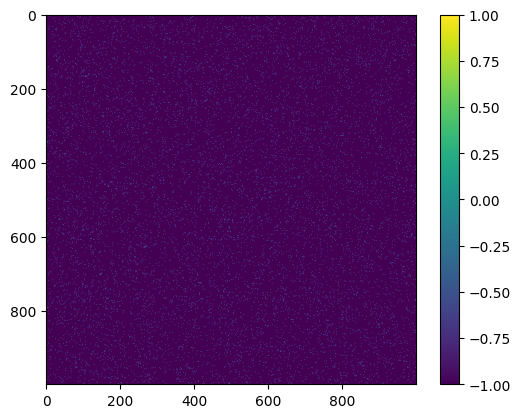

Elapsed time: 1.3765368461608887


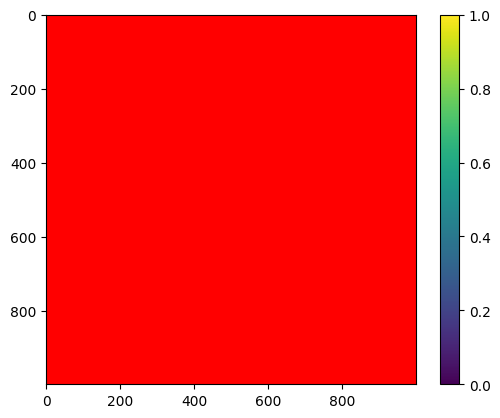

Elapsed time: 1.07515287399292


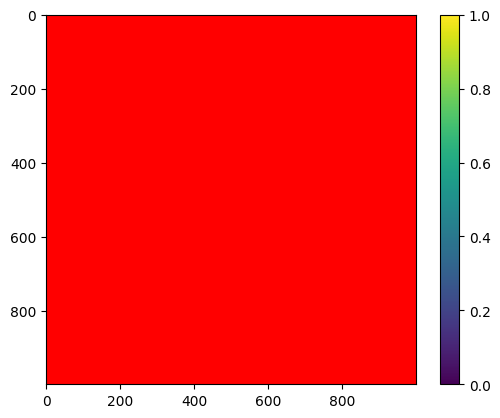

Elapsed time: 1.050403118133545


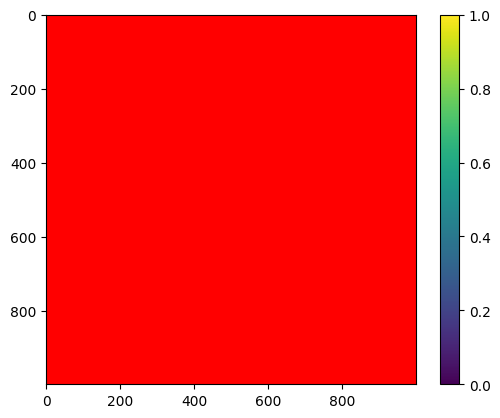

Elapsed time: 1.4980089664459229


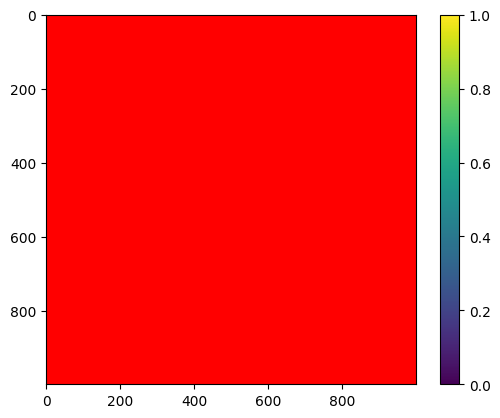

KeyboardInterrupt: 

In [ ]:
N = 1000
# random forest with 10% of trees infected.
initial_forest = np.random.choice([-1, 0, 1], size=(N, N), p=[0.99, 0.0, 0.01])
# initial_forest = np.ones((N, N))*-1
# initial_forest[4, 4] = 1
# plot the forest
import matplotlib.pyplot as plt
plt.imshow(initial_forest, cmap='viridis')
plt.colorbar()
plt.show()

 
test_age_list = np.random.randint(1, 100, (N, N))
#test_age_list = np.ones((N, N))*70
test_infection_time = np.random.rand(N, N)

while True:
    initial_forest = SpreadDisease(initial_forest, test_age_list, test_infection_time, 0.1)
    #plot the forest
    plt.imshow(initial_forest, cmap='viridis')
    # plot red point for trees with age > 81
    plt.colorbar()
    plt.show()
    if np.sum(initial_forest == -1) == 0:
        break

Elapsed time: 0.14031004905700684


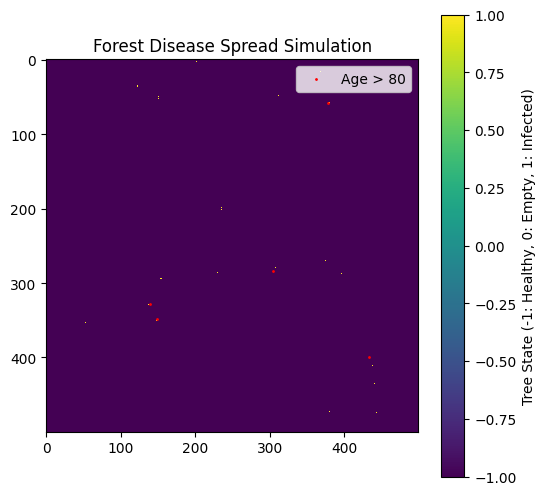

Elapsed time: 0.09972500801086426


<Figure size 640x480 with 0 Axes>

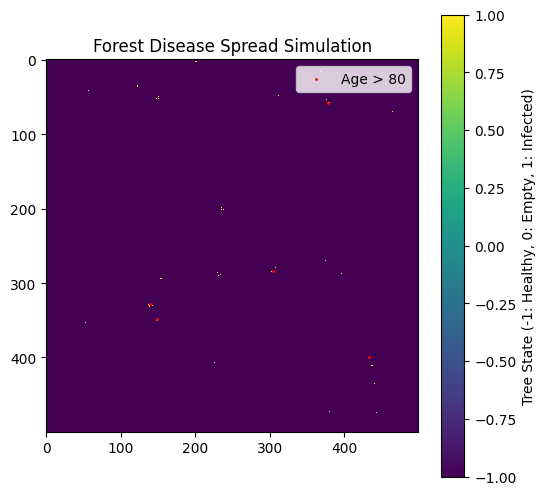

Elapsed time: 0.09106779098510742


<Figure size 640x480 with 0 Axes>

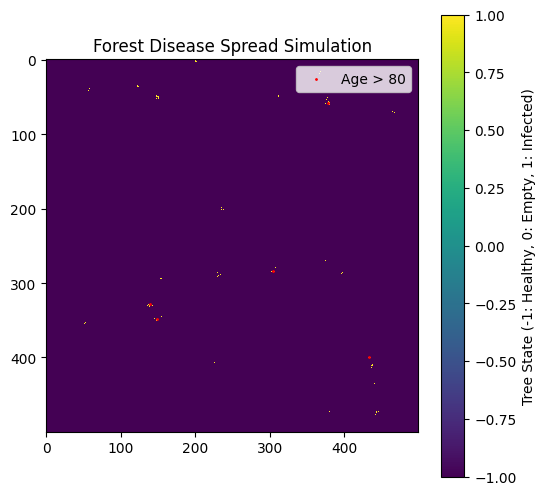

Elapsed time: 0.09356307983398438


<Figure size 640x480 with 0 Axes>

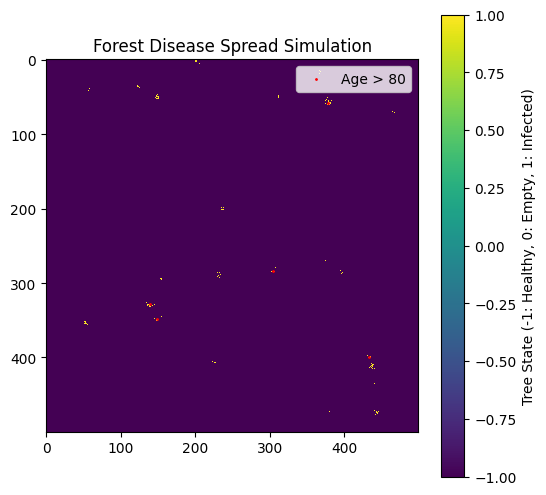

Elapsed time: 0.09581112861633301


<Figure size 640x480 with 0 Axes>

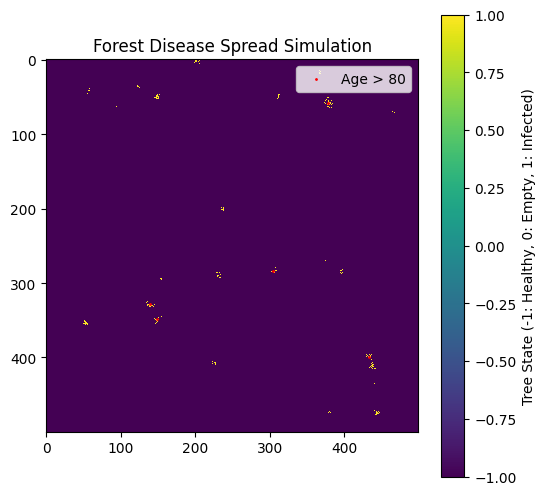

Elapsed time: 0.09555792808532715


<Figure size 640x480 with 0 Axes>

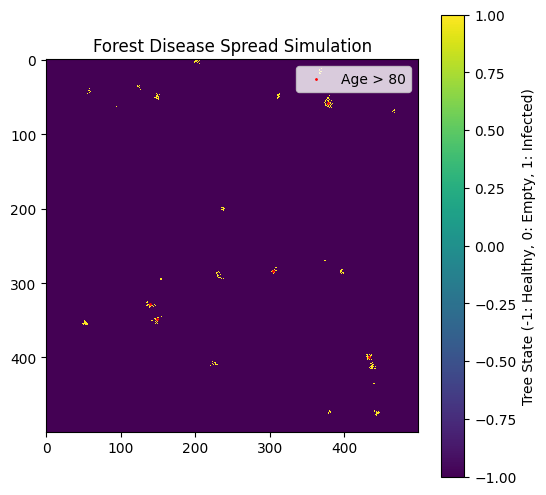

Elapsed time: 0.08468270301818848


<Figure size 640x480 with 0 Axes>

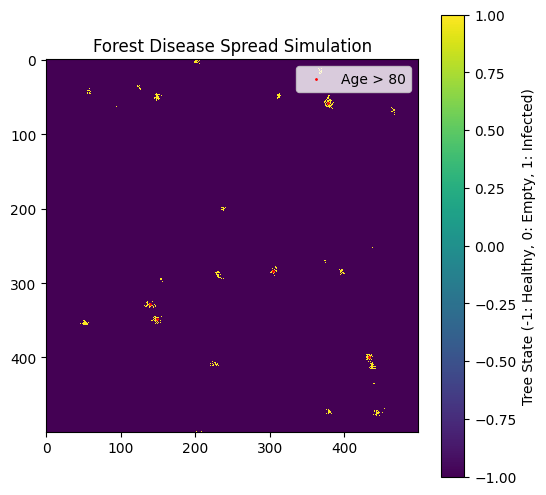

Elapsed time: 0.08973288536071777


<Figure size 640x480 with 0 Axes>

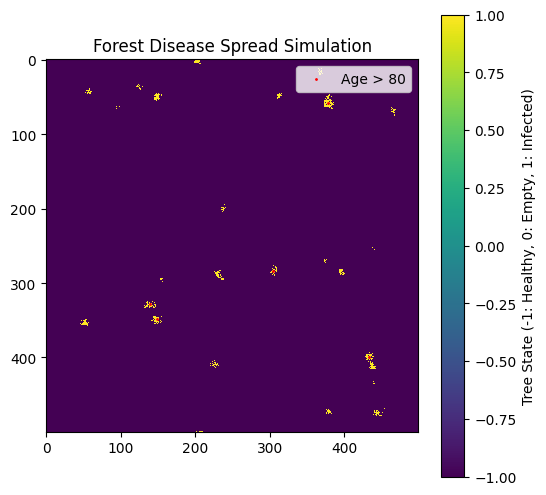

Elapsed time: 0.09269309043884277


<Figure size 640x480 with 0 Axes>

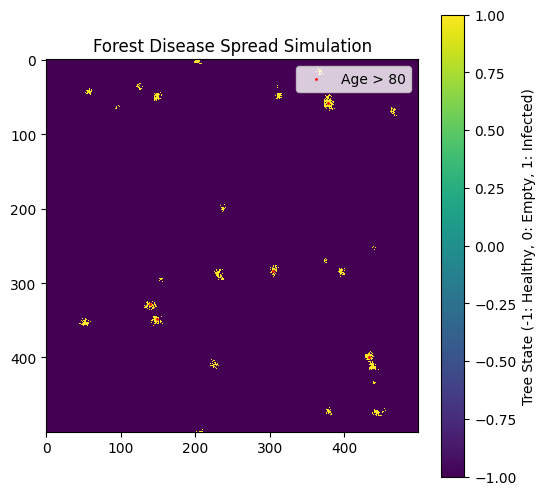

Elapsed time: 0.0851900577545166


<Figure size 640x480 with 0 Axes>

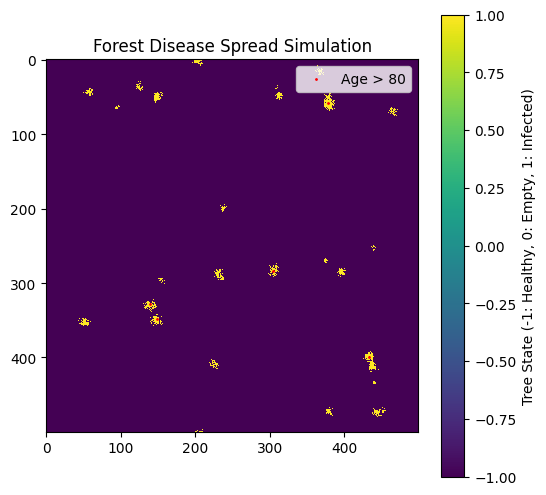

Elapsed time: 0.09325432777404785


<Figure size 640x480 with 0 Axes>

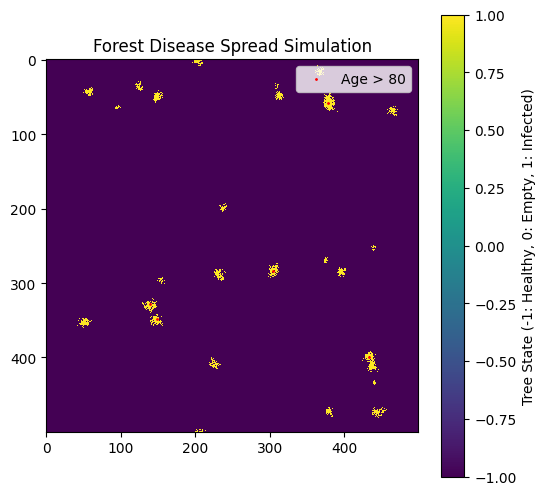

Elapsed time: 0.10099911689758301


<Figure size 640x480 with 0 Axes>

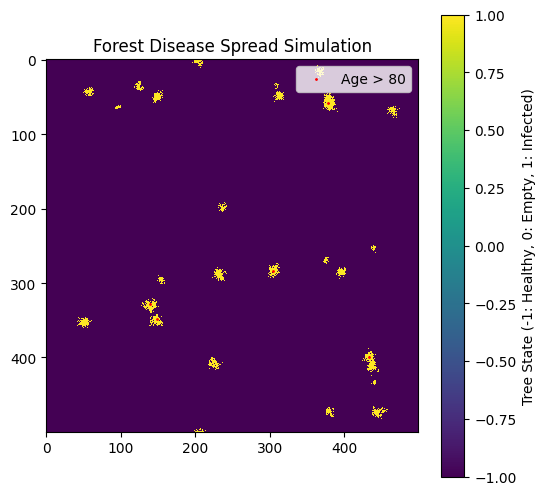

Elapsed time: 0.10498189926147461


<Figure size 640x480 with 0 Axes>

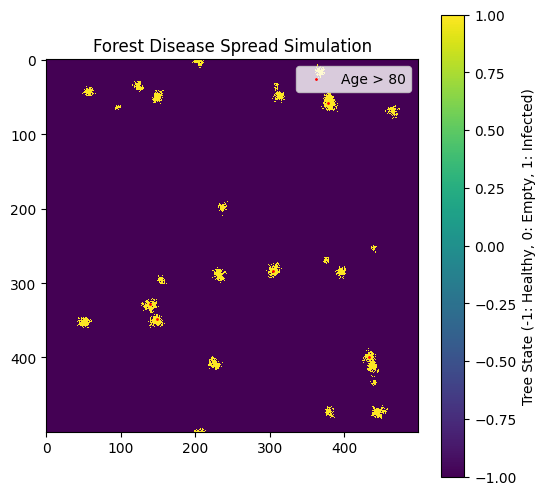

Elapsed time: 0.08193302154541016


<Figure size 640x480 with 0 Axes>

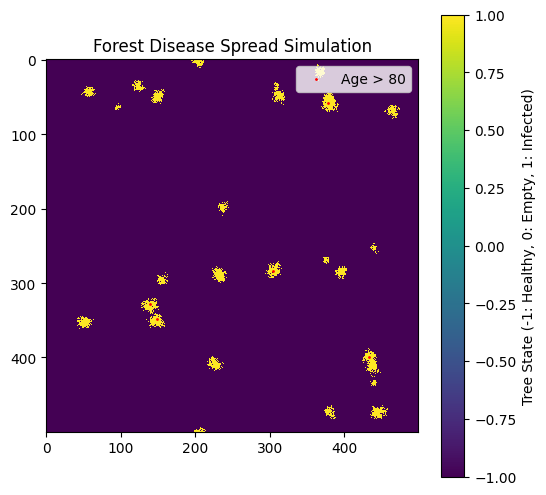

Elapsed time: 0.08931779861450195


<Figure size 640x480 with 0 Axes>

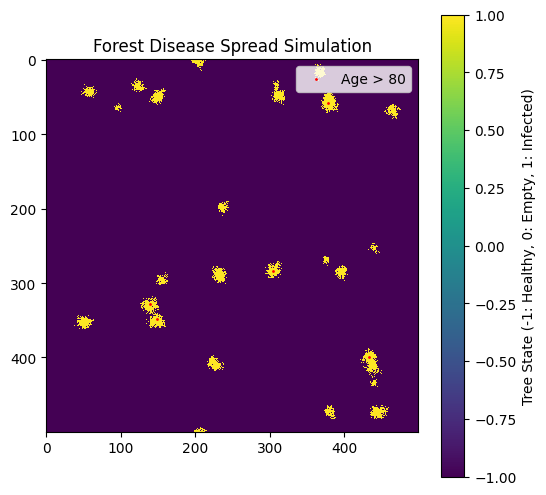

Elapsed time: 0.09222126007080078


<Figure size 640x480 with 0 Axes>

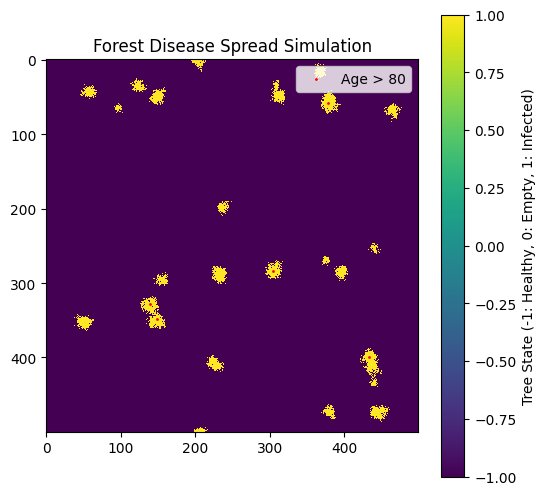

Elapsed time: 0.09348201751708984


<Figure size 640x480 with 0 Axes>

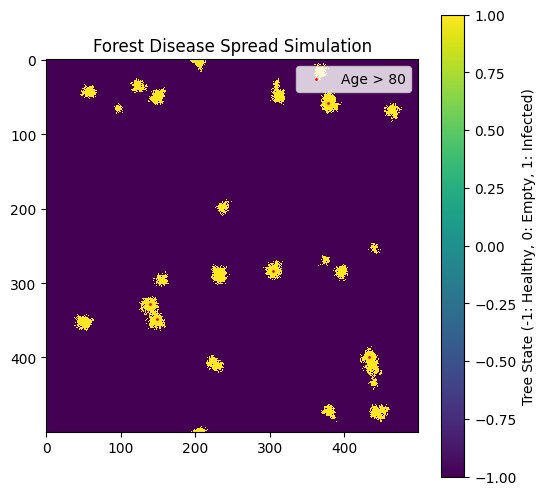

Elapsed time: 0.09009480476379395


<Figure size 640x480 with 0 Axes>

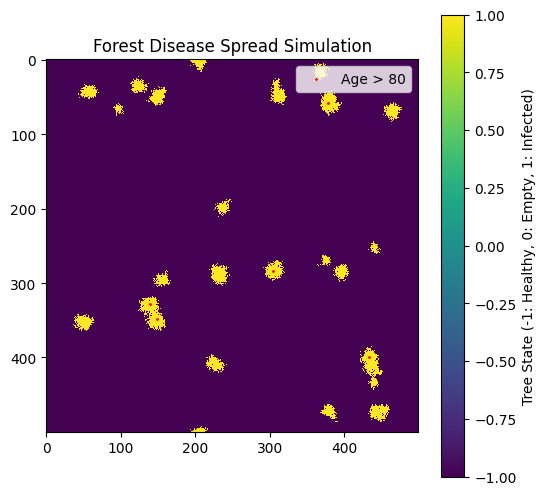

Elapsed time: 0.09047985076904297


<Figure size 640x480 with 0 Axes>

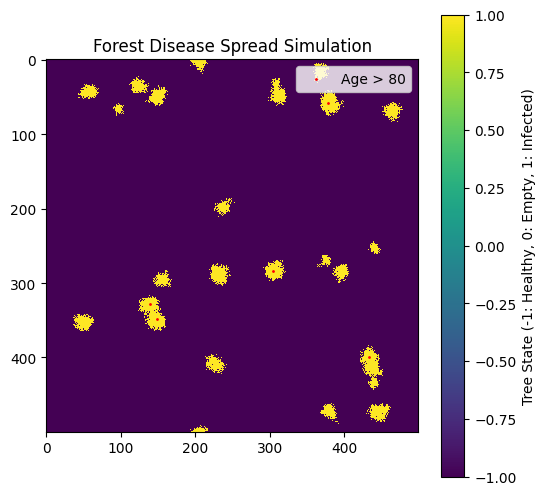

Elapsed time: 0.09116077423095703


<Figure size 640x480 with 0 Axes>

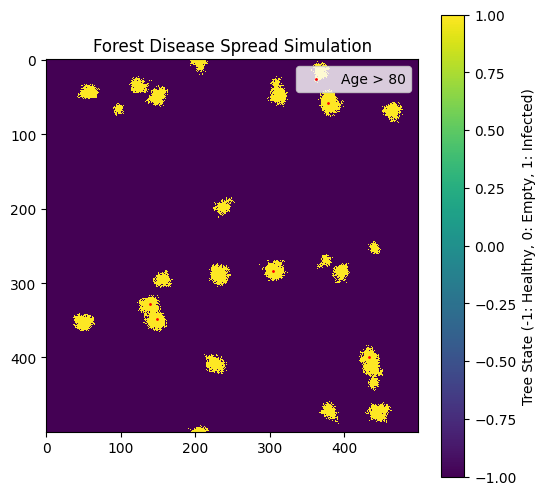

Elapsed time: 0.08592486381530762


<Figure size 640x480 with 0 Axes>

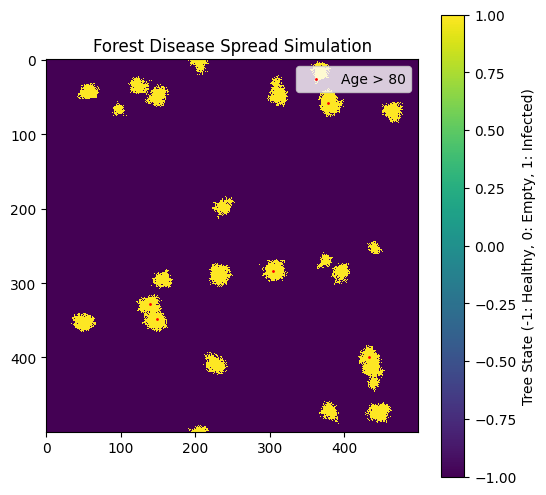

Elapsed time: 0.08863687515258789


<Figure size 640x480 with 0 Axes>

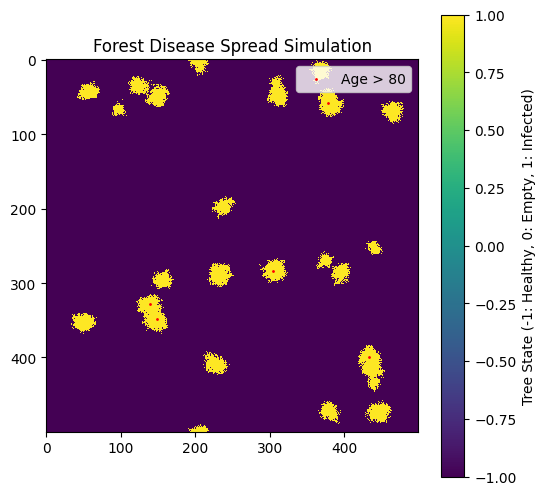

Elapsed time: 0.08875298500061035


<Figure size 640x480 with 0 Axes>

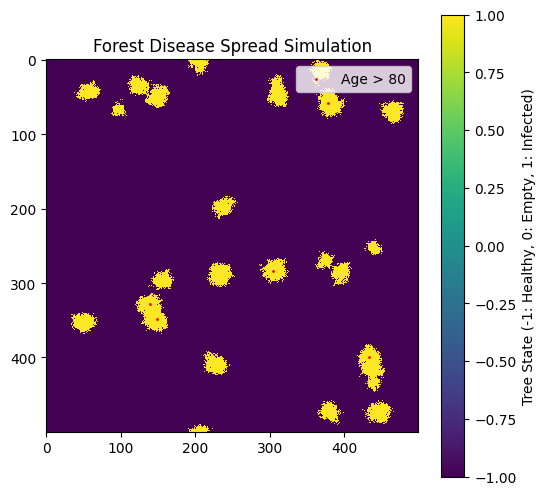

Elapsed time: 0.08557605743408203


<Figure size 640x480 with 0 Axes>

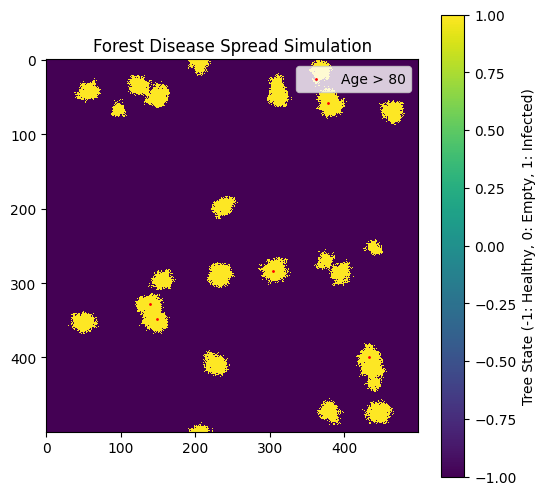

Elapsed time: 0.08617377281188965


<Figure size 640x480 with 0 Axes>

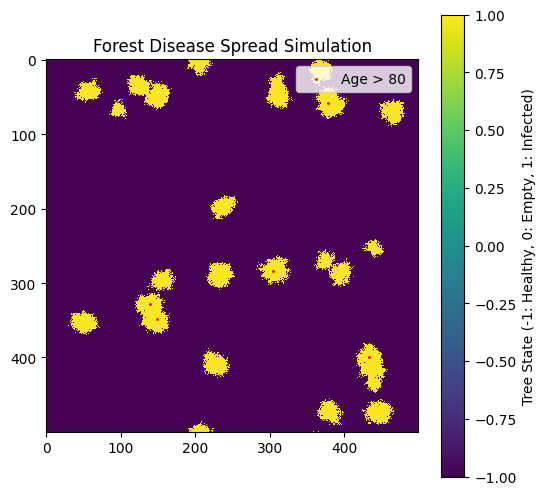

Elapsed time: 0.08456683158874512


<Figure size 640x480 with 0 Axes>

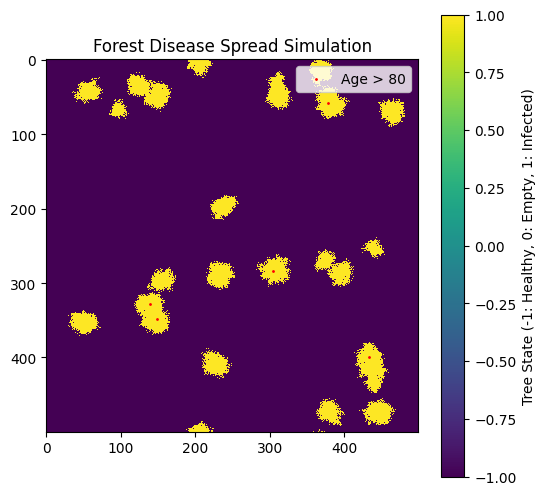

Elapsed time: 0.09026598930358887


<Figure size 640x480 with 0 Axes>

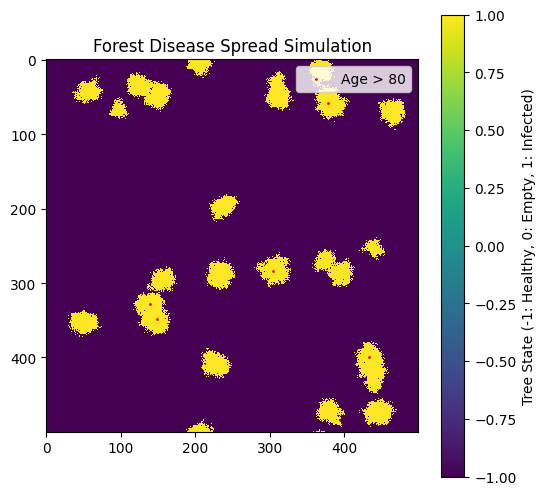

Elapsed time: 0.09331989288330078


<Figure size 640x480 with 0 Axes>

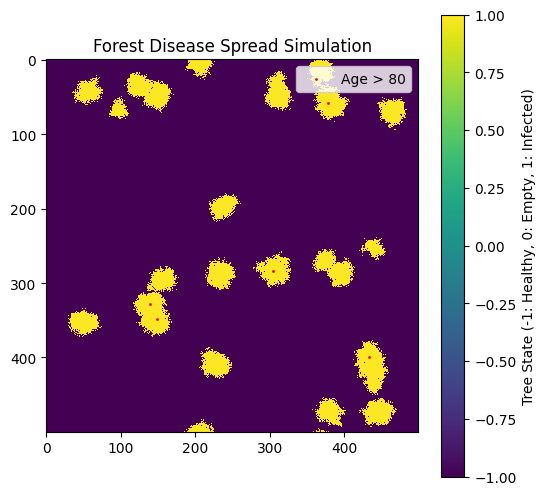

Elapsed time: 0.08796191215515137


<Figure size 640x480 with 0 Axes>

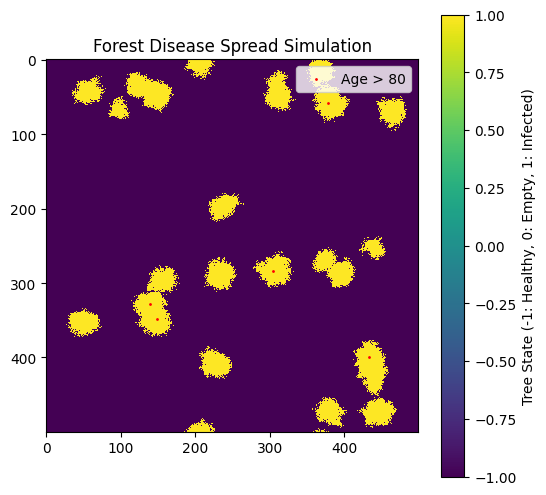

Elapsed time: 0.0953817367553711


<Figure size 640x480 with 0 Axes>

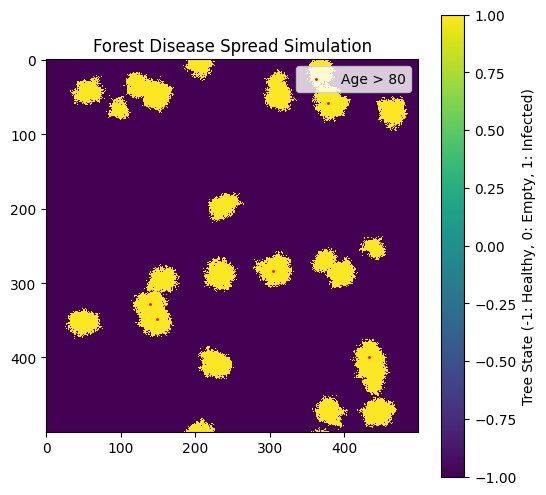

Elapsed time: 0.08671307563781738


<Figure size 640x480 with 0 Axes>

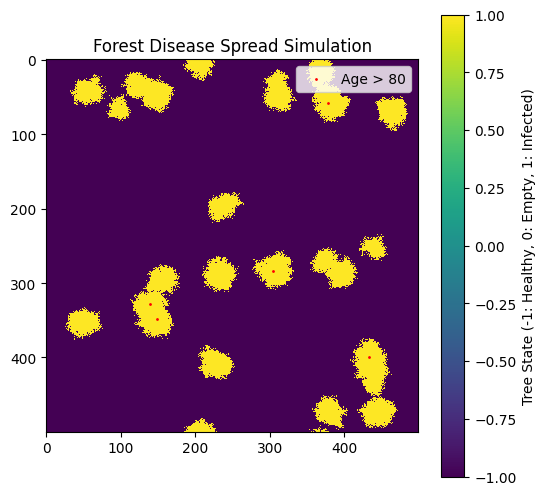

Elapsed time: 0.08923506736755371


<Figure size 640x480 with 0 Axes>

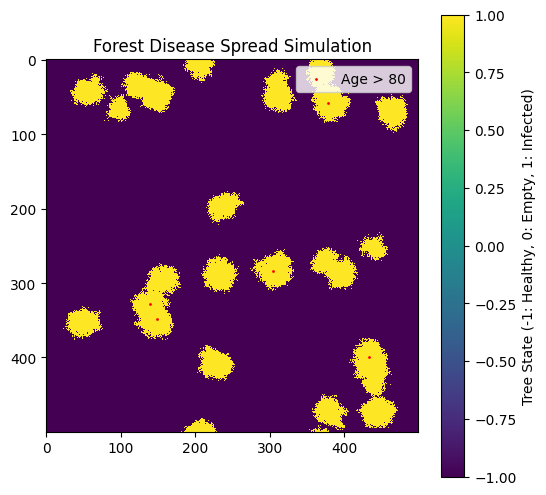

Elapsed time: 0.09029603004455566


<Figure size 640x480 with 0 Axes>

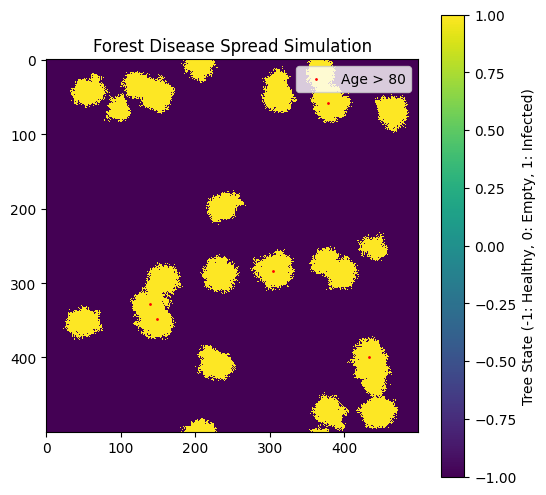

Elapsed time: 0.09935116767883301


<Figure size 640x480 with 0 Axes>

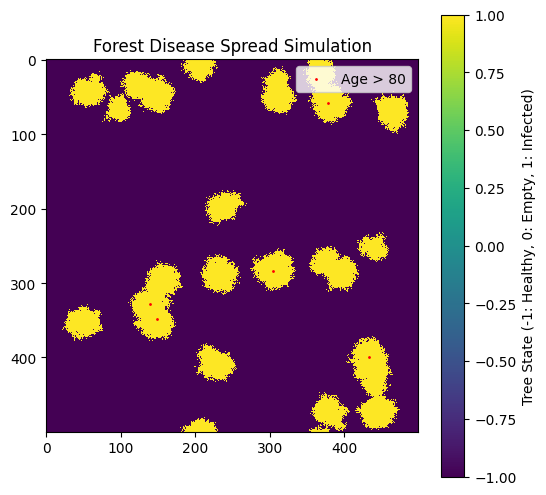

Elapsed time: 0.08881306648254395


<Figure size 640x480 with 0 Axes>

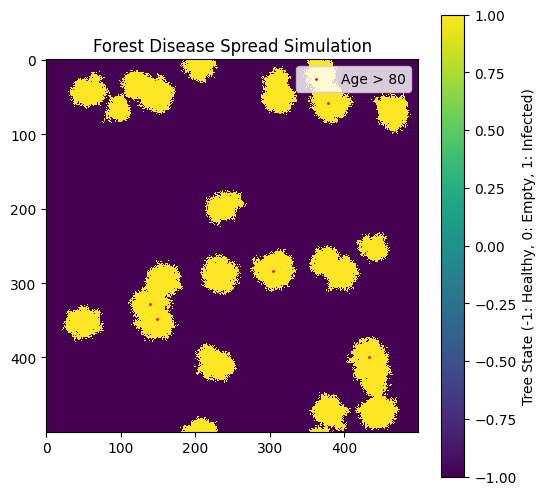

Elapsed time: 0.08887076377868652


<Figure size 640x480 with 0 Axes>

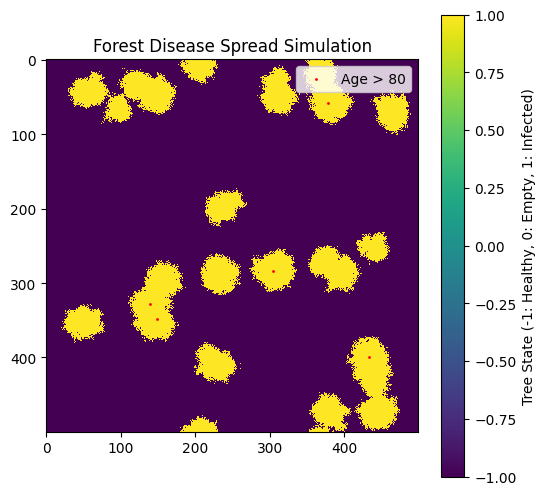

Elapsed time: 0.0933370590209961


<Figure size 640x480 with 0 Axes>

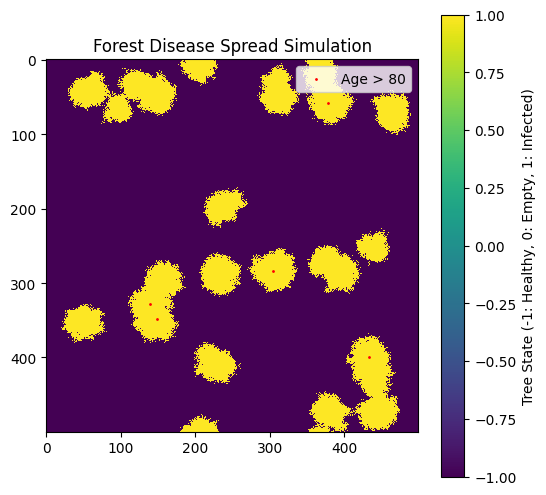

Elapsed time: 0.08295392990112305


<Figure size 640x480 with 0 Axes>

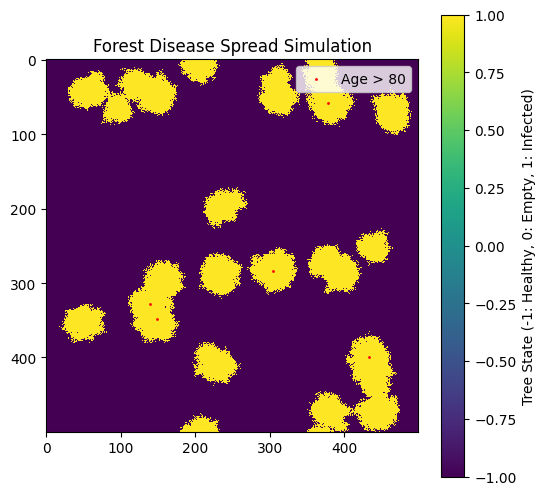

Elapsed time: 0.08406496047973633


<Figure size 640x480 with 0 Axes>

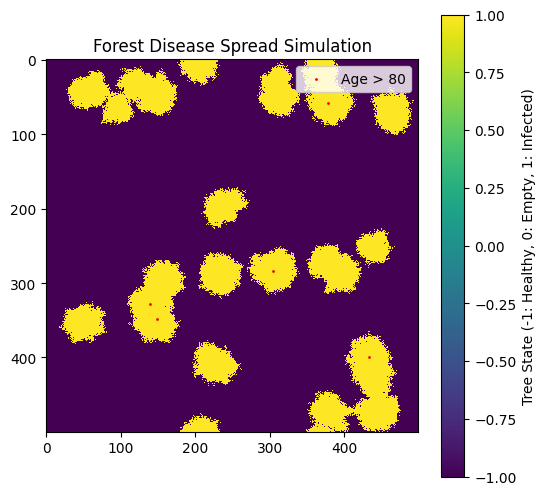

Elapsed time: 0.0883018970489502


<Figure size 640x480 with 0 Axes>

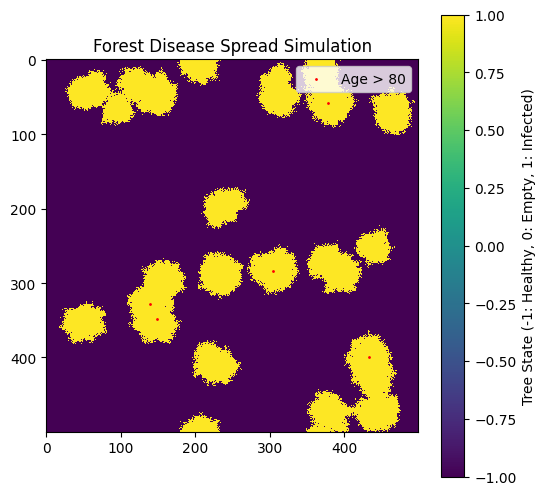

Elapsed time: 0.08427000045776367


<Figure size 640x480 with 0 Axes>

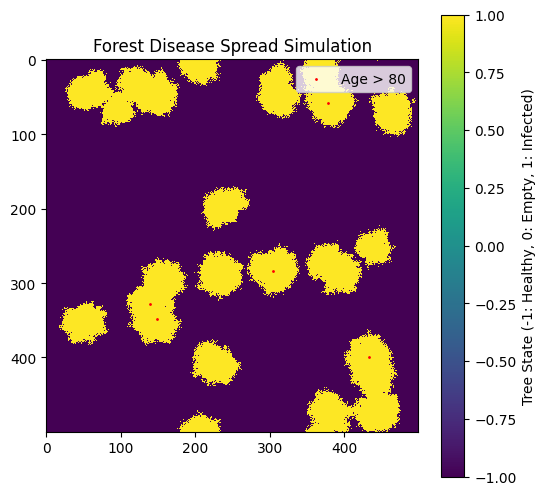

Elapsed time: 0.08760499954223633


<Figure size 640x480 with 0 Axes>

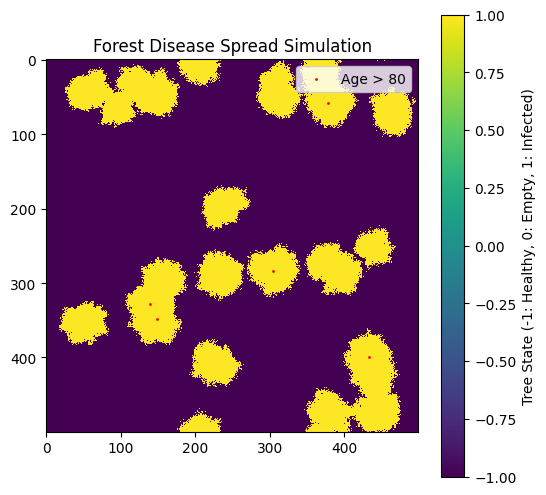

Elapsed time: 0.09107780456542969


<Figure size 640x480 with 0 Axes>

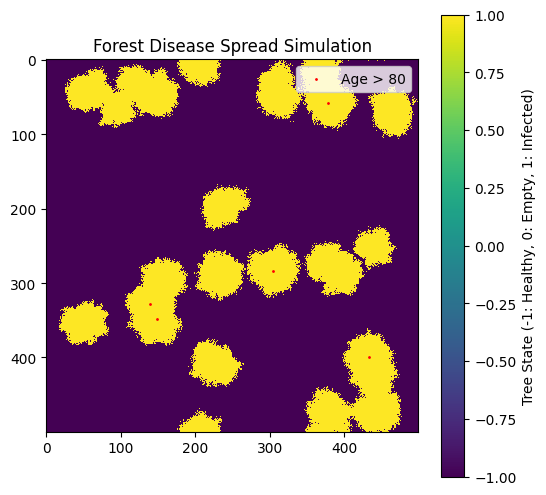

Elapsed time: 0.08716297149658203


<Figure size 640x480 with 0 Axes>

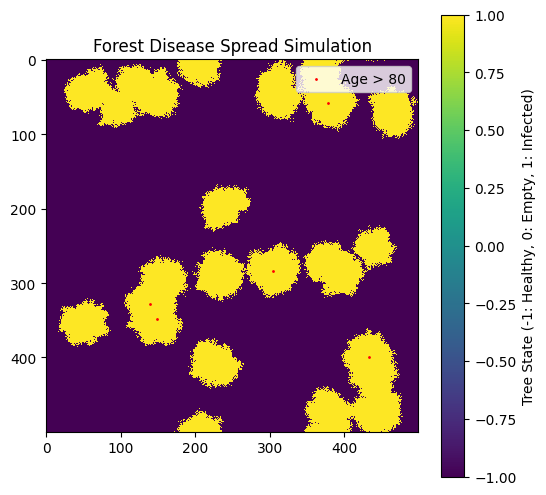

Elapsed time: 0.08296704292297363


<Figure size 640x480 with 0 Axes>

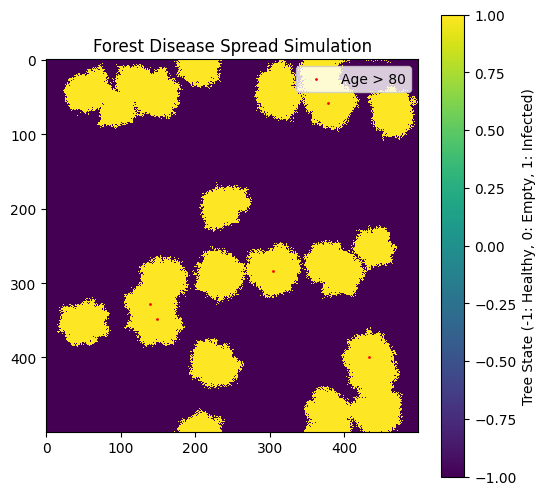

Elapsed time: 0.10499310493469238


<Figure size 640x480 with 0 Axes>

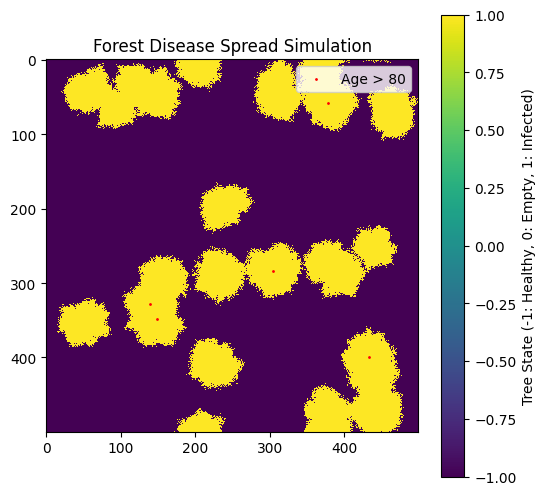

Elapsed time: 0.10818099975585938


<Figure size 640x480 with 0 Axes>

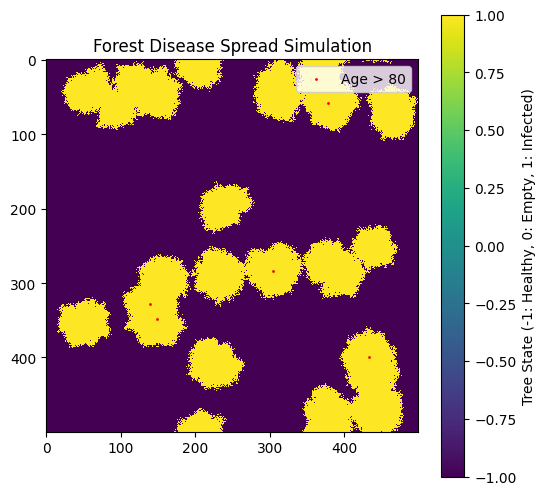

Elapsed time: 0.09037017822265625


<Figure size 640x480 with 0 Axes>

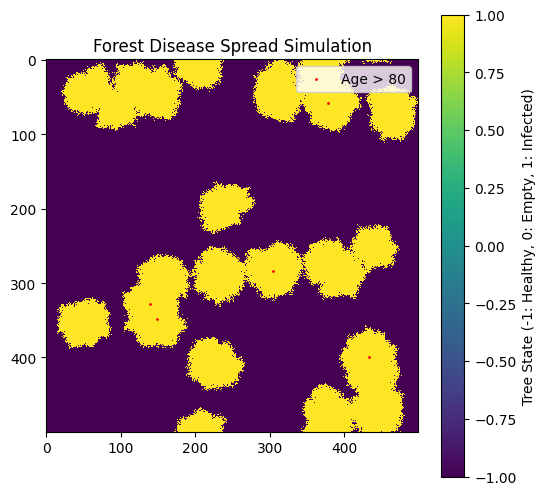

Elapsed time: 0.09285616874694824


<Figure size 640x480 with 0 Axes>

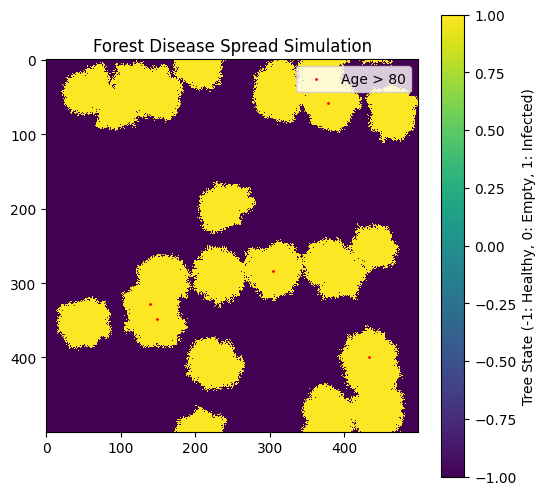

Elapsed time: 0.09382414817810059


<Figure size 640x480 with 0 Axes>

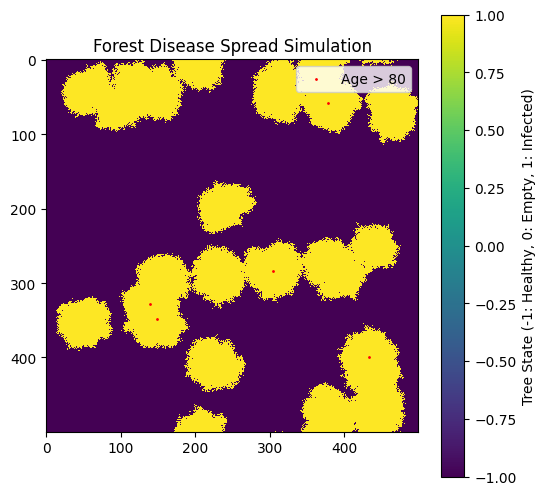

Elapsed time: 0.08115386962890625


<Figure size 640x480 with 0 Axes>

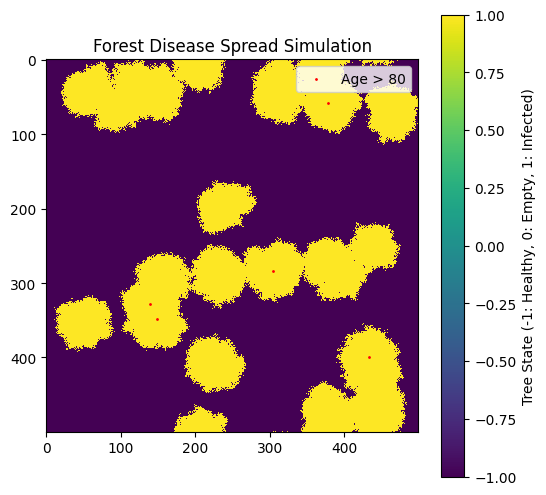

Elapsed time: 0.08990693092346191


<Figure size 640x480 with 0 Axes>

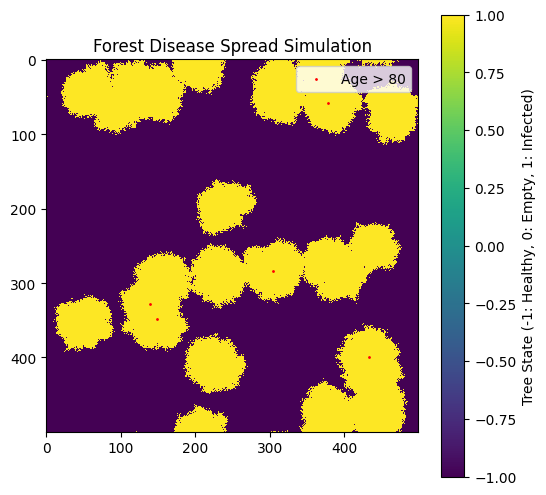

Elapsed time: 0.08554506301879883


<Figure size 640x480 with 0 Axes>

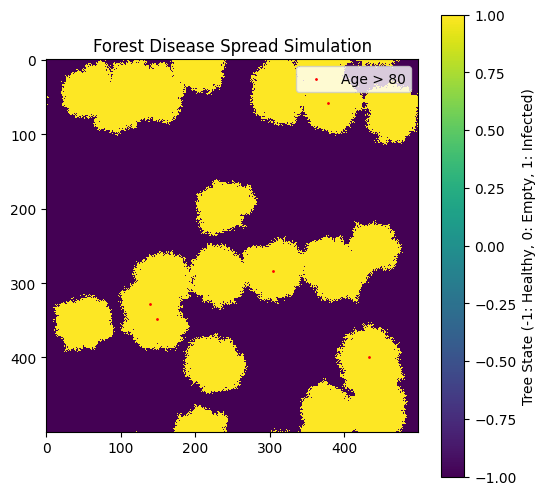

Elapsed time: 0.08039188385009766


<Figure size 640x480 with 0 Axes>

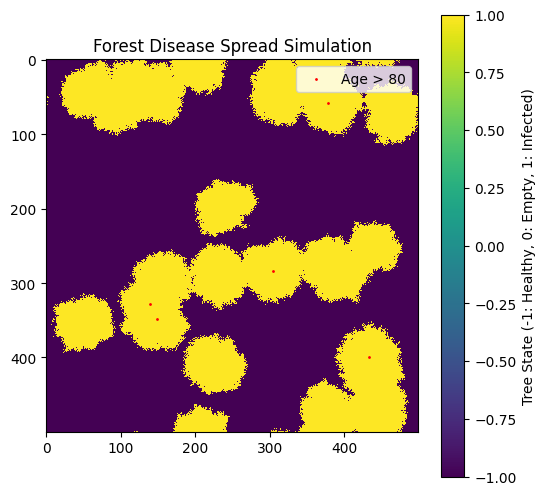

Elapsed time: 0.09294986724853516


<Figure size 640x480 with 0 Axes>

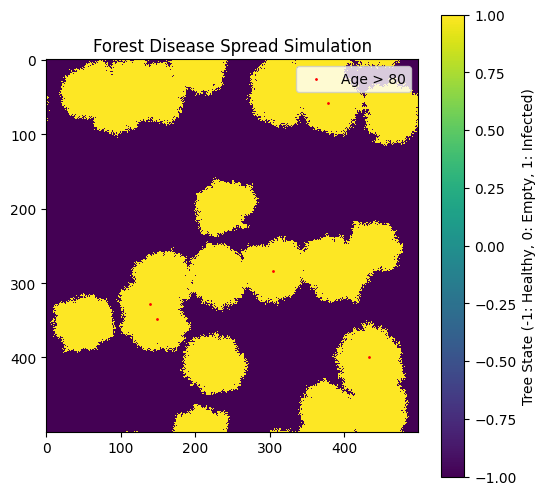

Elapsed time: 0.0843818187713623


<Figure size 640x480 with 0 Axes>

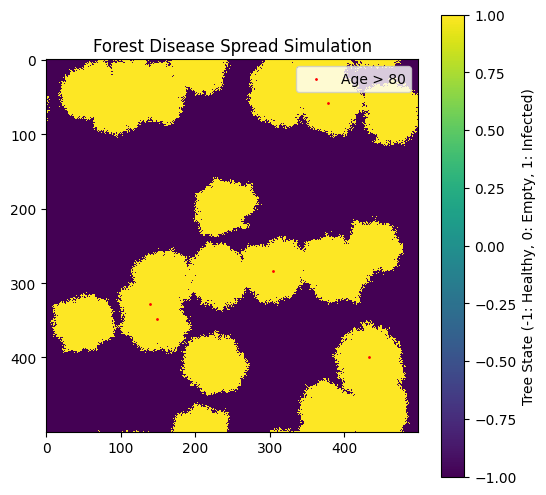

Elapsed time: 0.0803530216217041


<Figure size 640x480 with 0 Axes>

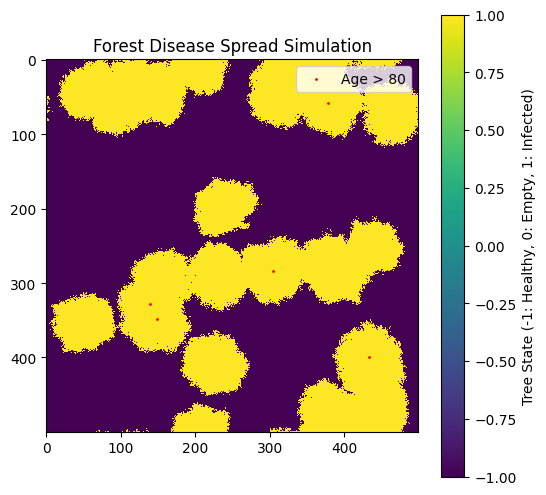

Elapsed time: 0.10723996162414551


<Figure size 640x480 with 0 Axes>

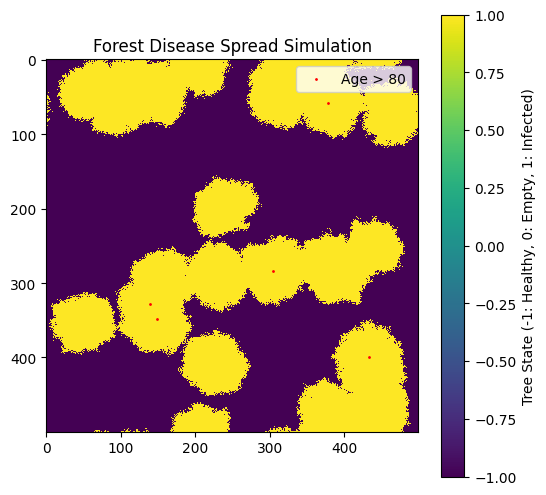

Elapsed time: 0.08530116081237793


<Figure size 640x480 with 0 Axes>

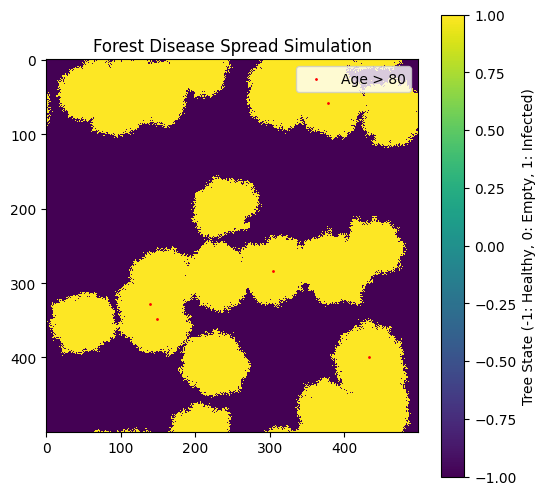

Elapsed time: 0.08022499084472656


<Figure size 640x480 with 0 Axes>

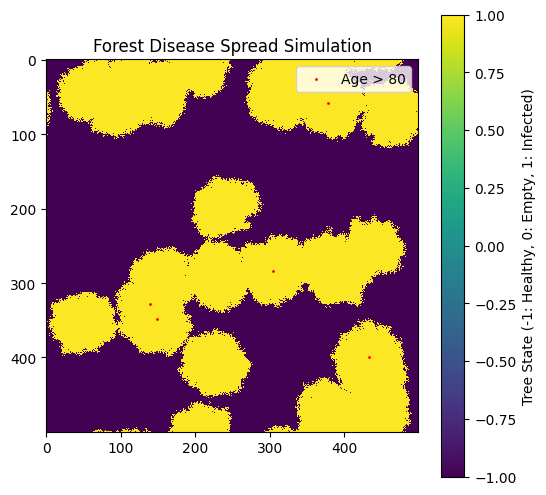

Elapsed time: 0.08591103553771973


<Figure size 640x480 with 0 Axes>

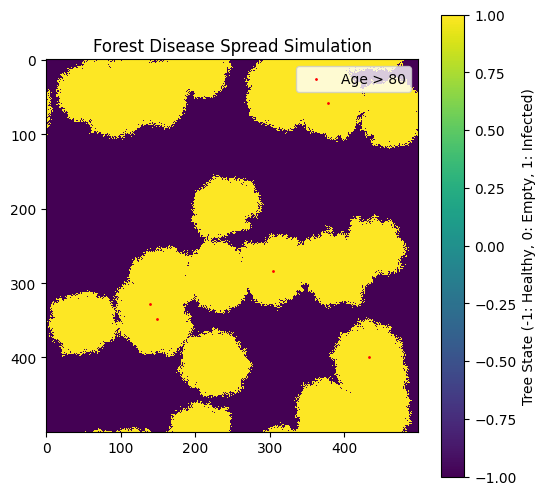

Elapsed time: 0.08649396896362305


<Figure size 640x480 with 0 Axes>

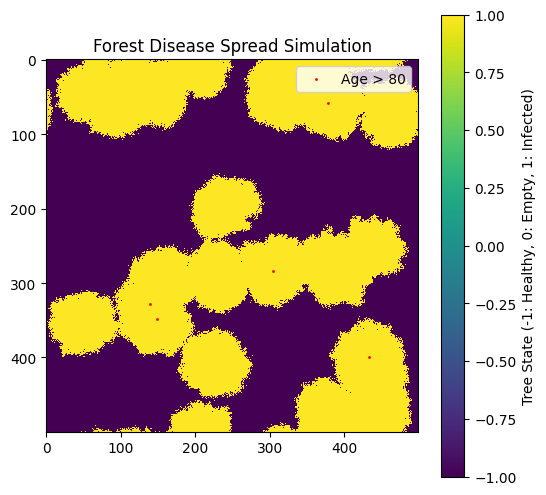

Elapsed time: 0.08099794387817383


<Figure size 640x480 with 0 Axes>

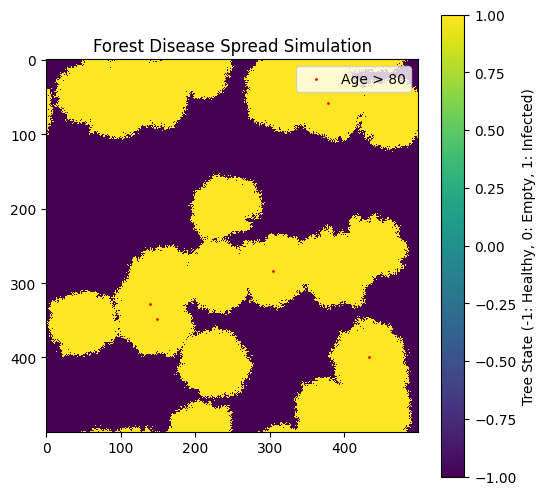

Elapsed time: 0.08536481857299805


<Figure size 640x480 with 0 Axes>

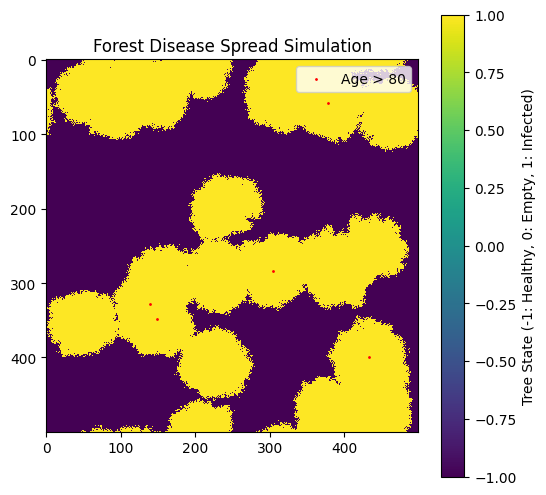

Elapsed time: 0.09242582321166992


<Figure size 640x480 with 0 Axes>

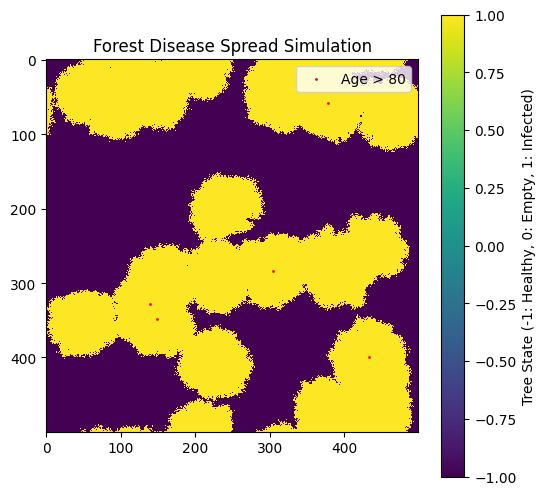

Elapsed time: 0.07792806625366211


<Figure size 640x480 with 0 Axes>

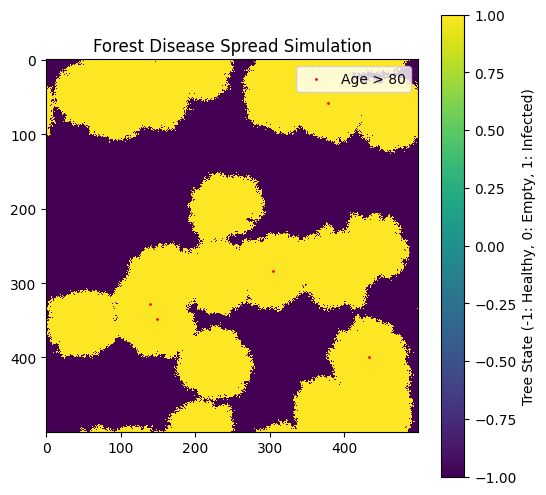

Elapsed time: 0.08275318145751953


<Figure size 640x480 with 0 Axes>

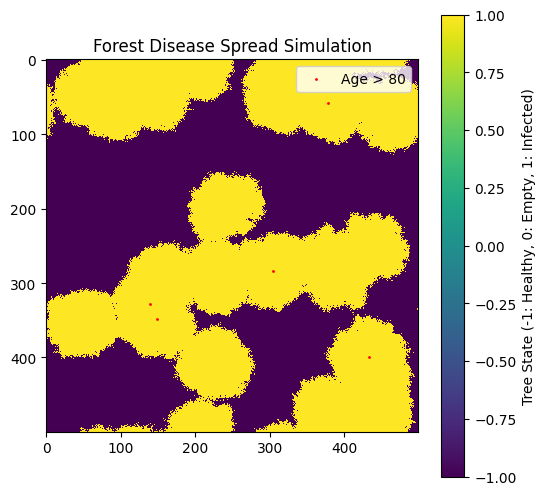

Elapsed time: 0.08989429473876953


<Figure size 640x480 with 0 Axes>

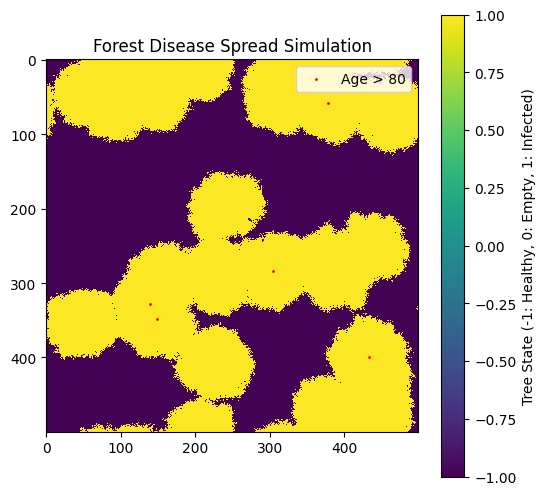

Elapsed time: 0.08204007148742676


<Figure size 640x480 with 0 Axes>

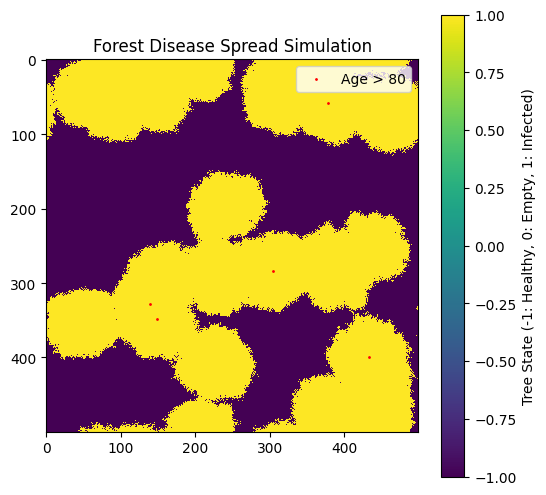

Elapsed time: 0.08445405960083008


<Figure size 640x480 with 0 Axes>

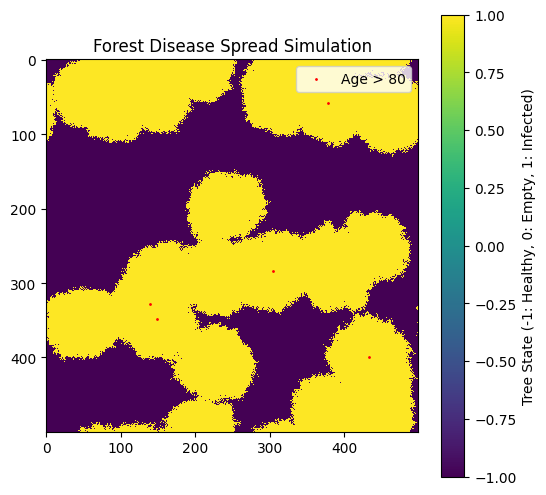

Elapsed time: 0.0904231071472168


<Figure size 640x480 with 0 Axes>

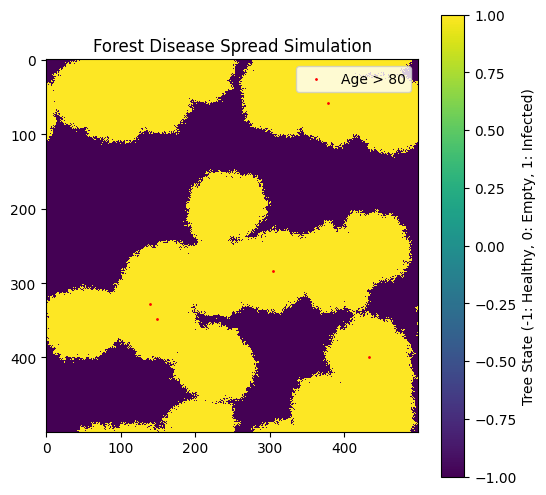

Elapsed time: 0.09492015838623047


<Figure size 640x480 with 0 Axes>

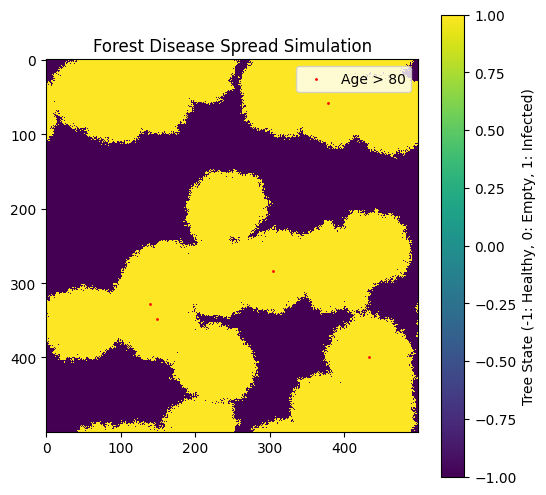

Elapsed time: 0.09434199333190918


<Figure size 640x480 with 0 Axes>

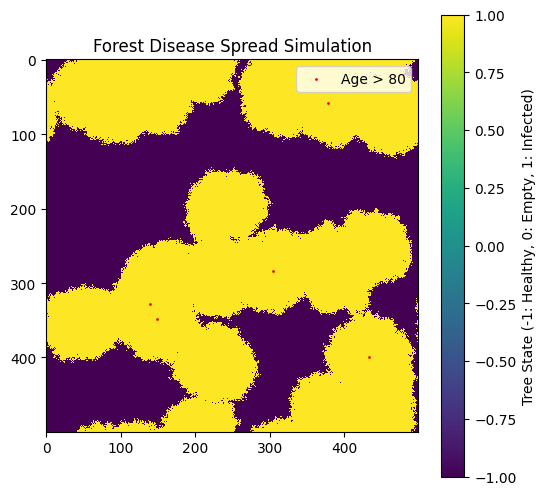

Elapsed time: 0.08328914642333984


<Figure size 640x480 with 0 Axes>

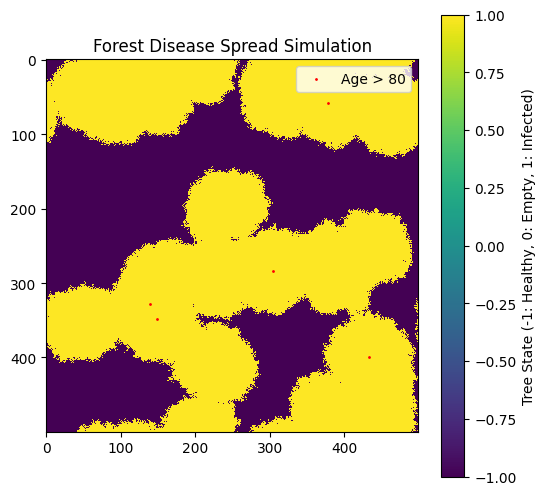

Elapsed time: 0.09049177169799805


<Figure size 640x480 with 0 Axes>

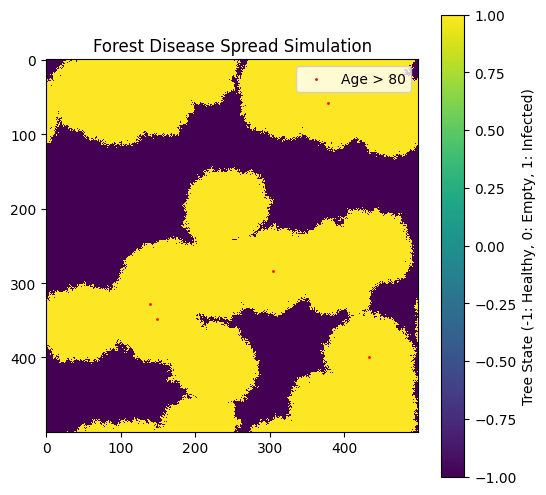

Elapsed time: 0.08083605766296387


<Figure size 640x480 with 0 Axes>

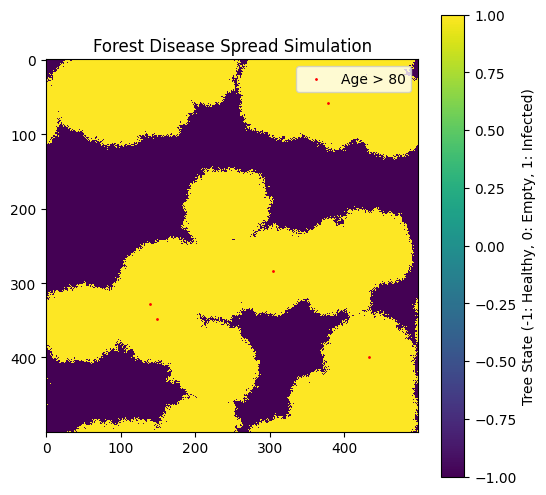

Elapsed time: 0.08513092994689941


<Figure size 640x480 with 0 Axes>

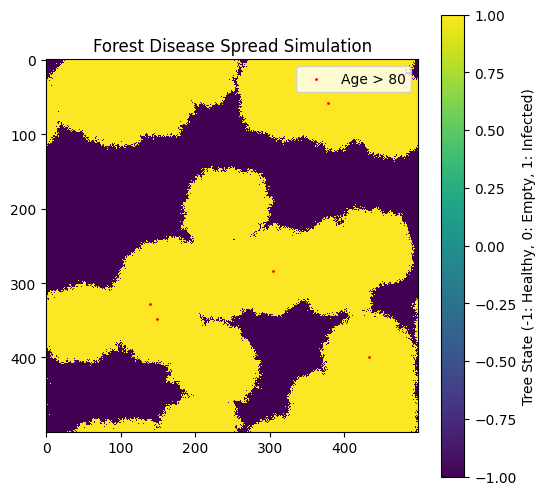

Elapsed time: 0.08213400840759277


<Figure size 640x480 with 0 Axes>

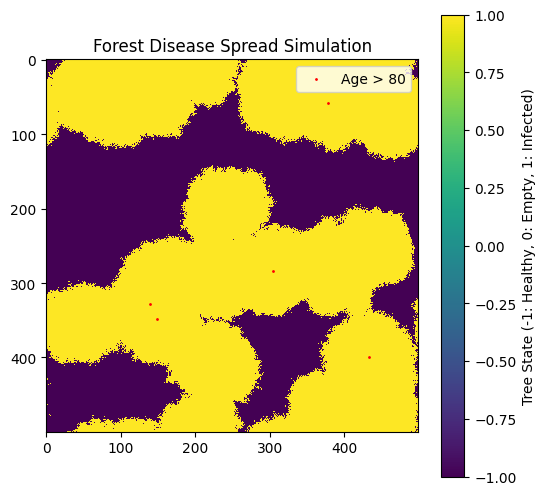

Elapsed time: 0.09962773323059082


<Figure size 640x480 with 0 Axes>

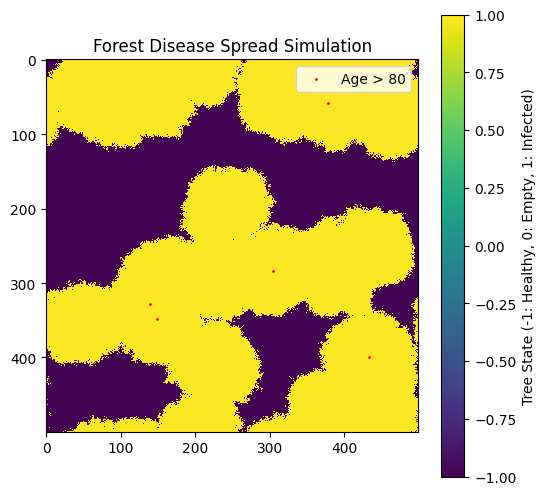

Elapsed time: 0.08604979515075684


<Figure size 640x480 with 0 Axes>

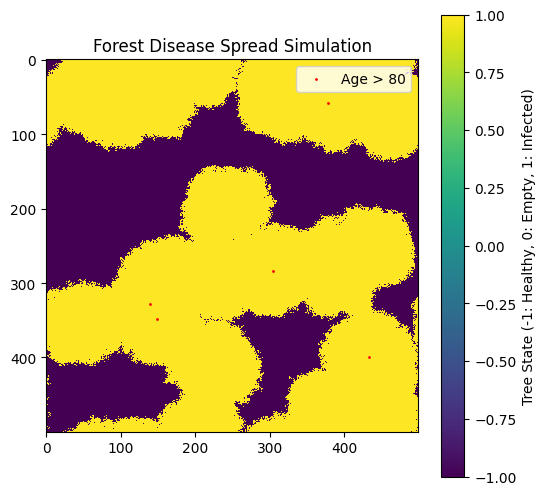

Elapsed time: 0.09306883811950684


<Figure size 640x480 with 0 Axes>

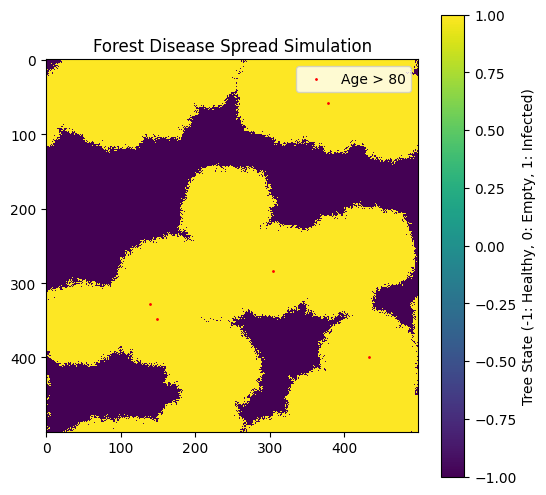

Elapsed time: 0.08580875396728516


<Figure size 640x480 with 0 Axes>

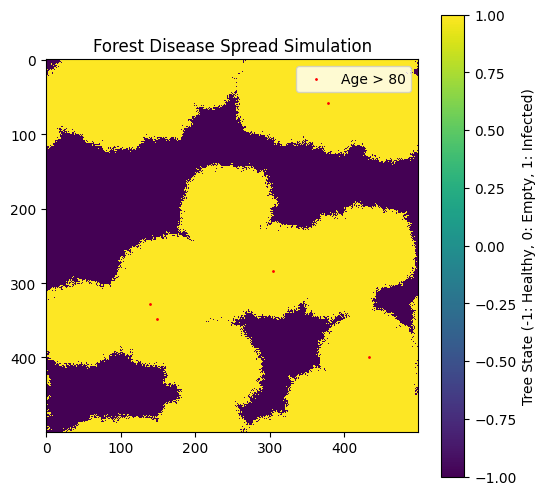

Elapsed time: 0.0848989486694336


<Figure size 640x480 with 0 Axes>

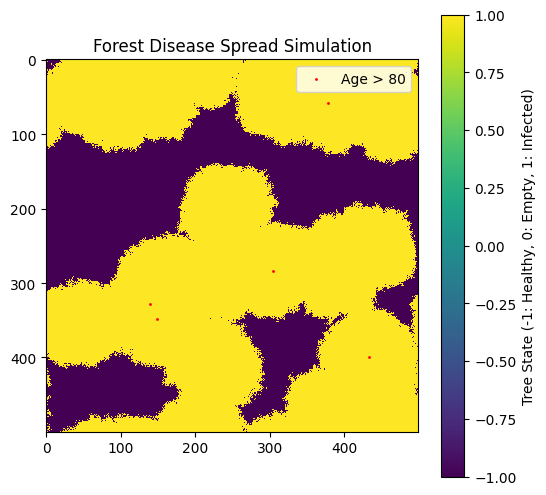

Elapsed time: 0.08413076400756836


<Figure size 640x480 with 0 Axes>

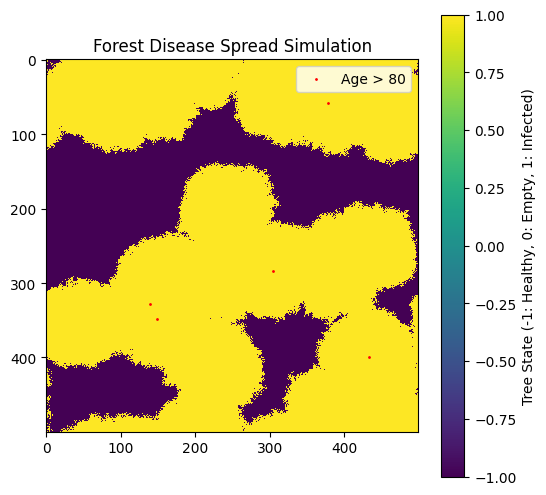

Elapsed time: 0.08440399169921875


<Figure size 640x480 with 0 Axes>

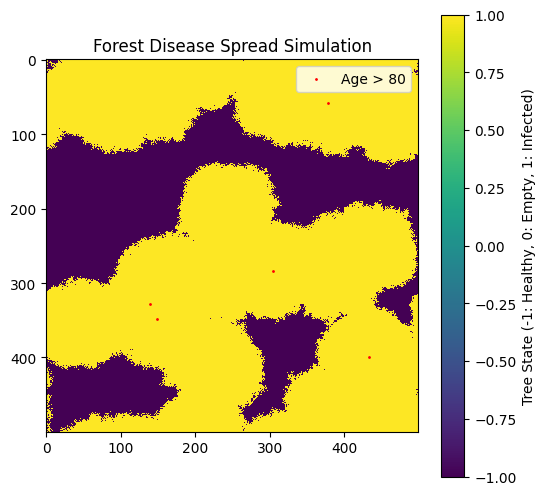

Elapsed time: 0.09650206565856934


<Figure size 640x480 with 0 Axes>

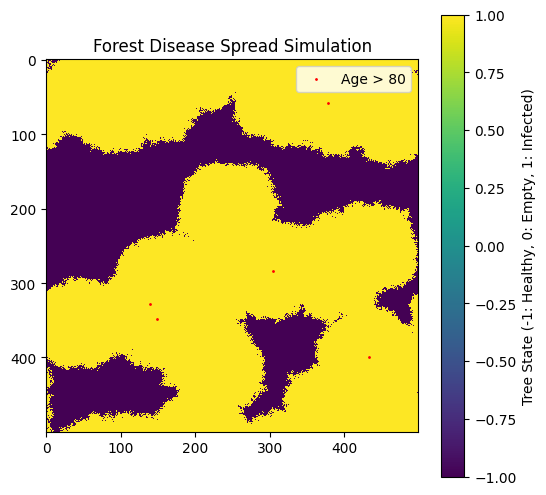

Elapsed time: 0.08571219444274902


<Figure size 640x480 with 0 Axes>

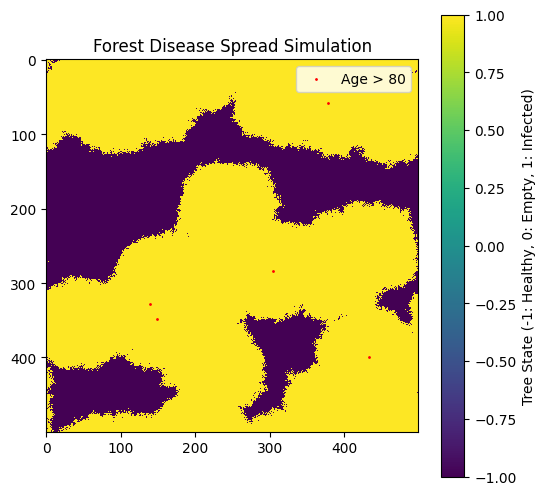

Elapsed time: 0.08831501007080078


<Figure size 640x480 with 0 Axes>

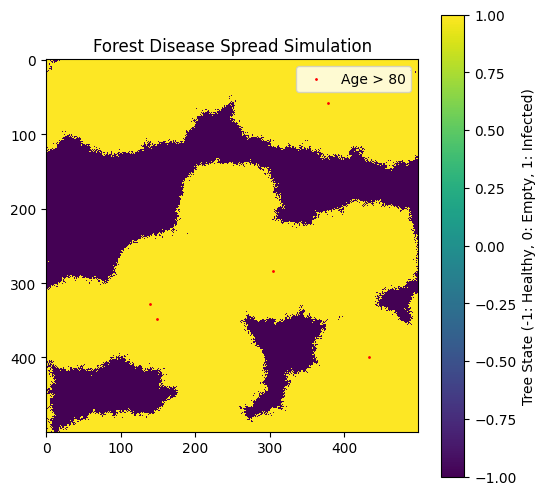

Elapsed time: 0.08515310287475586


<Figure size 640x480 with 0 Axes>

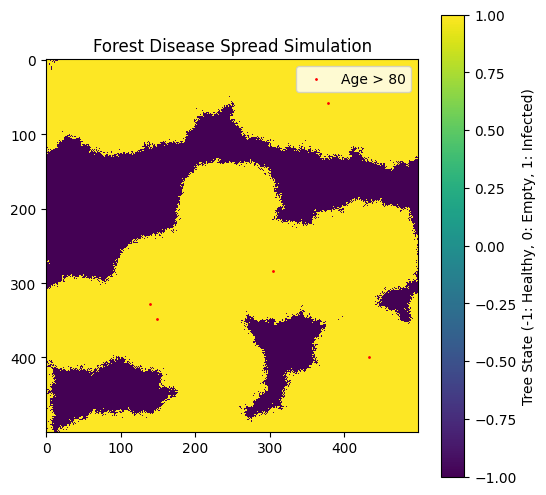

Elapsed time: 0.08205294609069824


<Figure size 640x480 with 0 Axes>

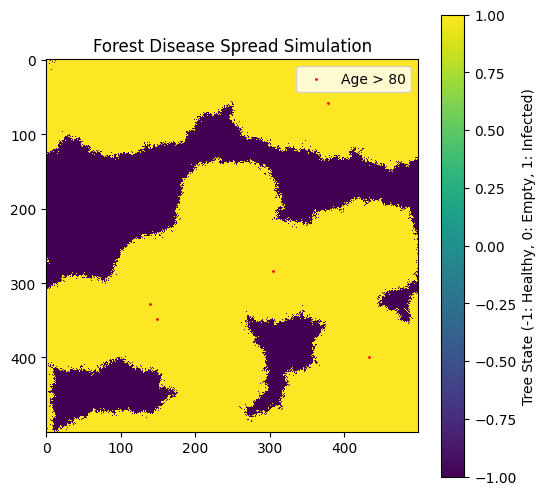

Elapsed time: 0.09839987754821777


<Figure size 640x480 with 0 Axes>

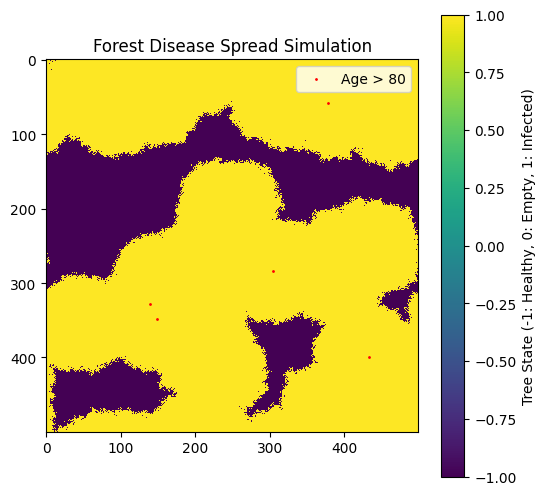

Elapsed time: 0.08177304267883301


<Figure size 640x480 with 0 Axes>

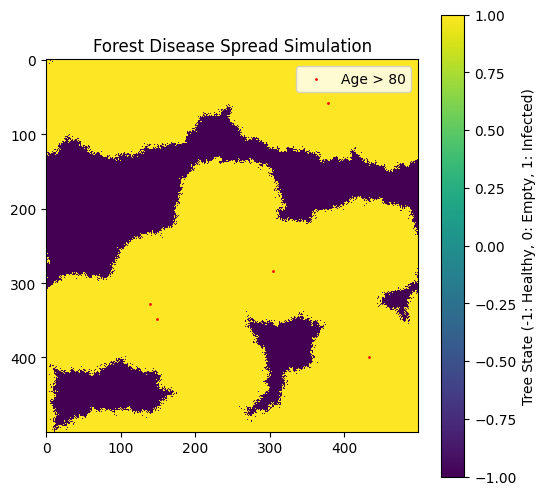

Elapsed time: 0.08441400527954102


<Figure size 640x480 with 0 Axes>

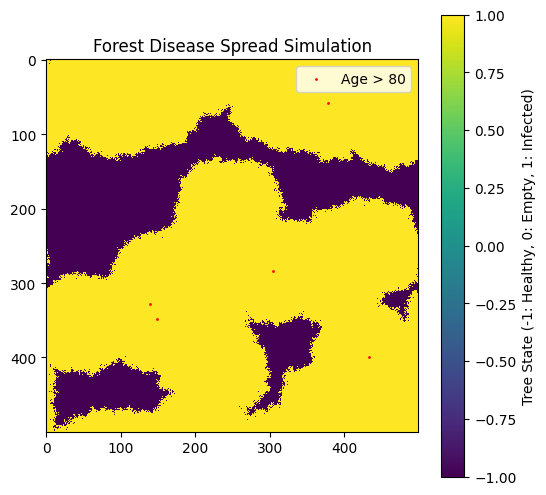

Elapsed time: 0.0944209098815918


<Figure size 640x480 with 0 Axes>

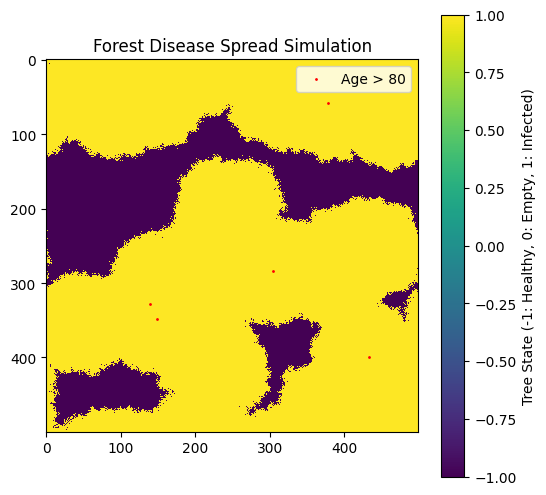

Elapsed time: 0.0835270881652832


<Figure size 640x480 with 0 Axes>

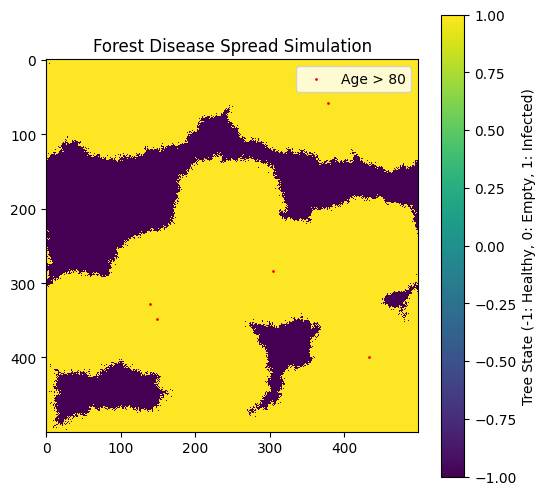

Elapsed time: 0.08998703956604004


<Figure size 640x480 with 0 Axes>

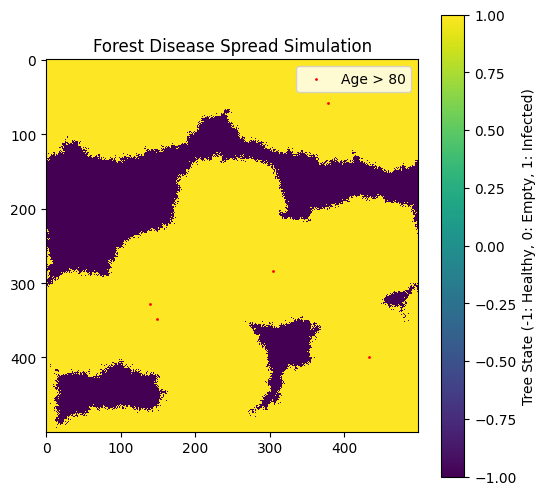

Elapsed time: 0.09068727493286133


<Figure size 640x480 with 0 Axes>

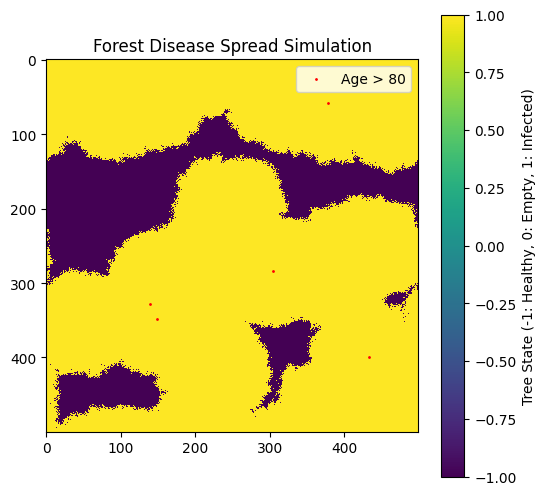

Elapsed time: 0.0870211124420166


<Figure size 640x480 with 0 Axes>

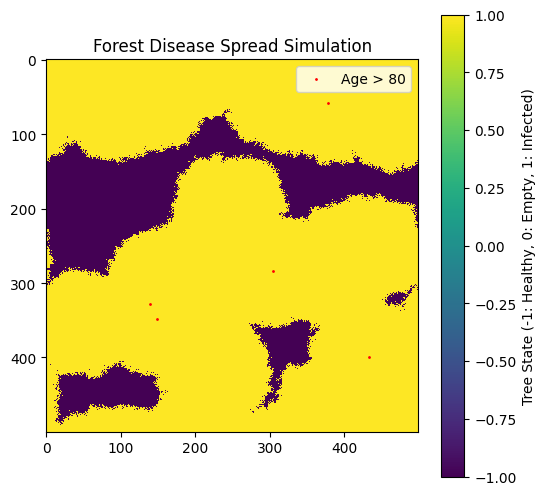

Elapsed time: 0.09839320182800293


<Figure size 640x480 with 0 Axes>

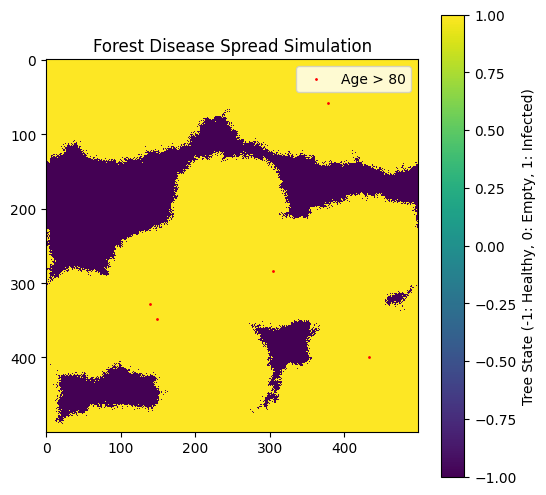

Elapsed time: 0.08698797225952148


<Figure size 640x480 with 0 Axes>

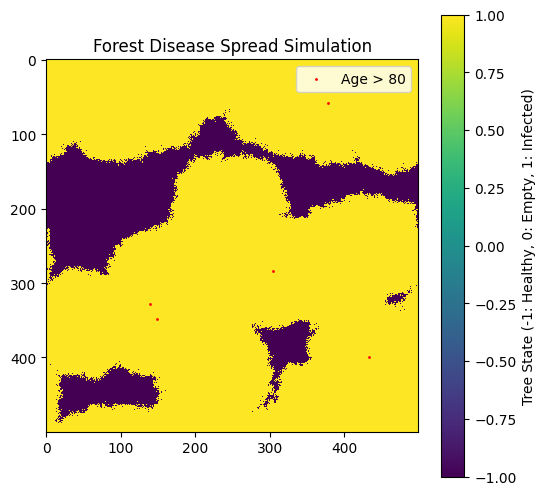

Elapsed time: 0.09474682807922363


<Figure size 640x480 with 0 Axes>

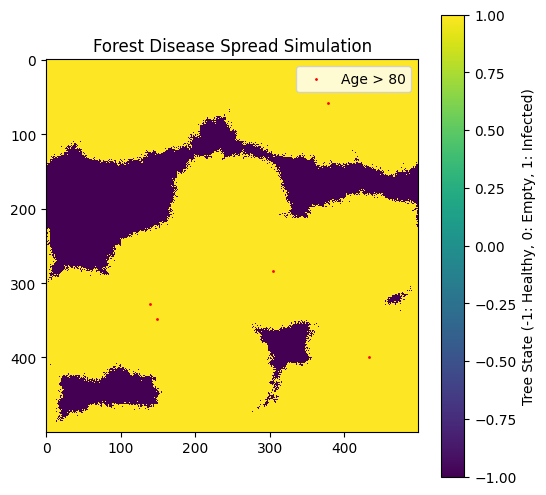

Elapsed time: 0.08718514442443848


<Figure size 640x480 with 0 Axes>

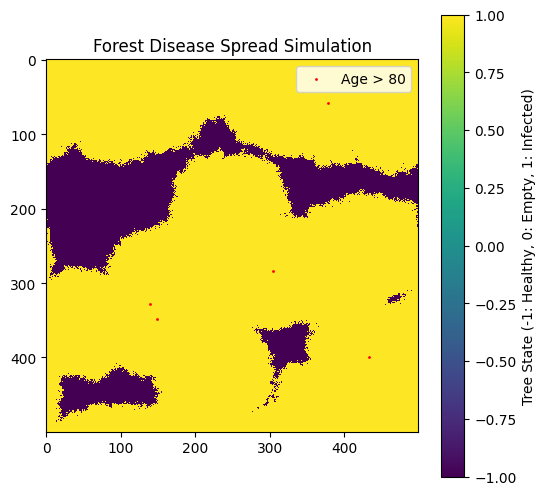

Elapsed time: 0.0831148624420166


<Figure size 640x480 with 0 Axes>

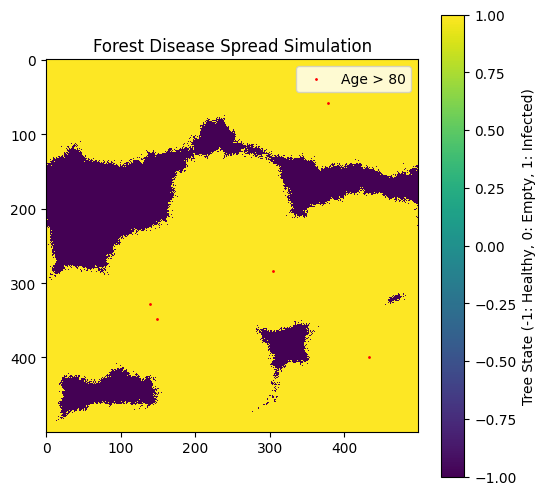

Elapsed time: 0.08595395088195801


<Figure size 640x480 with 0 Axes>

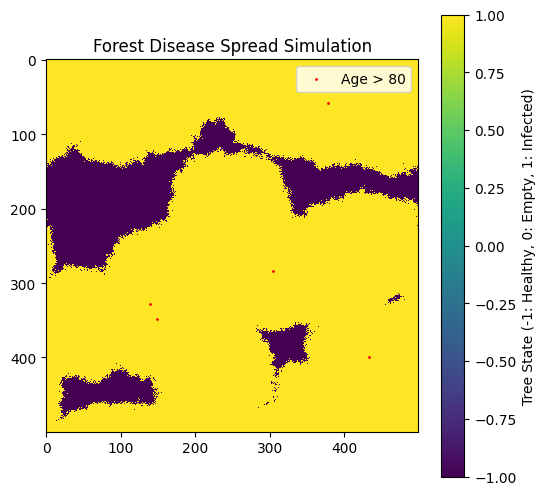

Elapsed time: 0.08075094223022461


<Figure size 640x480 with 0 Axes>

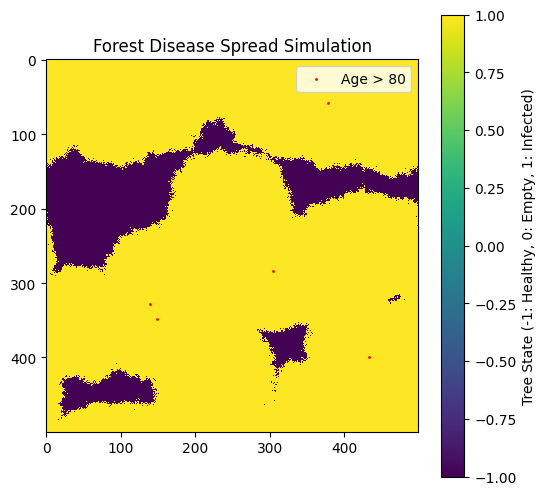

Elapsed time: 0.108367919921875


<Figure size 640x480 with 0 Axes>

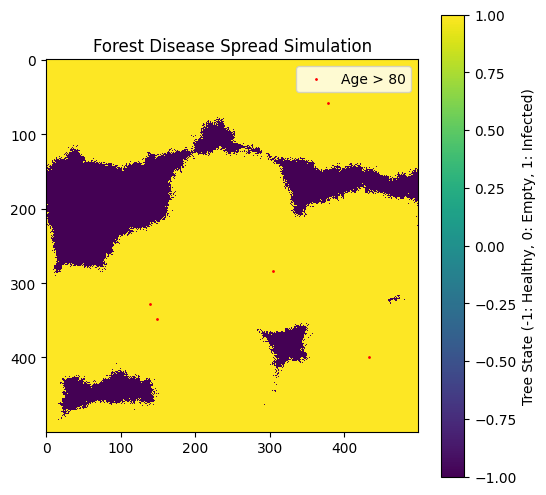

Elapsed time: 0.09088587760925293


<Figure size 640x480 with 0 Axes>

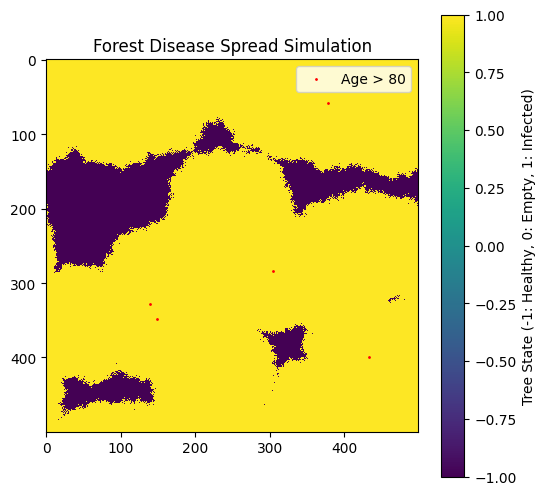

Elapsed time: 0.08358025550842285


<Figure size 640x480 with 0 Axes>

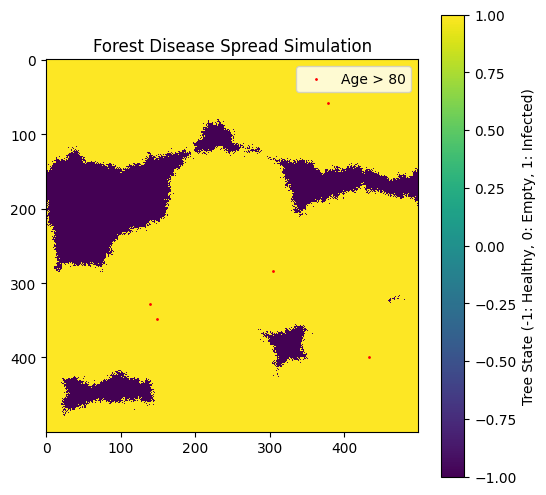

KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Disease Spread Simulation Function (using the implemented Disease_Spread)


# Parameters
N = 500  # Forest size
# Generate a random forest where 10% of trees are infected
initial_forest = np.random.choice([-1, 0, 1], size=(N, N), p=[0.9999, 0.0, 0.0001])

# Generate test age list and infection time
test_age_list = np.random.randint(1, 59, (N, N))  # Random ages between 1 and 100

# set 1% of the trees to age = 100
test_age_list[np.random.choice(N, int(N * 0.01)), np.random.choice(N, int(N * 0.01))] = 100

# set trees with age > 80 to be infected
initial_forest[test_age_list > 80] = 1


test_infection_time = np.random.rand(N, N)  # Random infection times

# Visualization setup
plt.ion()  # Interactive mode for dynamic updates

while True:
    # Update the forest state using SpreadDisease
    initial_forest = SpreadDisease(initial_forest, test_age_list, test_infection_time, 0.05)
    
    # Plot the forest state
    plt.figure(figsize=(6, 6))
    plt.imshow(initial_forest, cmap='viridis', interpolation='nearest')
    plt.title("Forest Disease Spread Simulation")
    plt.colorbar(label="Tree State (-1: Healthy, 0: Empty, 1: Infected)")

    # Highlight trees with age > 80
    age_high_indices = np.argwhere(test_age_list > 80)
    plt.scatter(age_high_indices[:, 1], age_high_indices[:, 0], c='red', s=1, label='Age > 80')
    
    plt.legend(loc='upper right')
    plt.pause(0.1)
    plt.clf()  # Clear the figure for the next frame

    #test_age_list += 1  # Increment the age of all trees

    # Check termination condition: all healthy trees are infected
    if np.sum(initial_forest == -1) == 0:
        plt.ioff()  # Turn off interactive mode
        plt.show()
        print("All healthy trees have been infected.")
        break


In [ ]:
# Transform kernel into PyTorch tensor and expand dimensions
#kernel = np.ones((3, 3))
kernel = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(3, 3)
print('kernel:', kernel)
p_spread = 1
#infected = np.array([1, 0, 1, 3, 2, 1, 2, 3, 1]).reshape(3, 3)
# random infected matrix with shape (5, 5) value in [0, 1]
infected = np.random.rand(5, 5)
infected = torch.tensor(infected, dtype=torch.float32)
infected_pad = F.pad(infected.unsqueeze(0).unsqueeze(0), (1, 1, 1, 1), mode='circular')
#print('infected_pad:', infected_pad)
infected_unfolded = F.unfold(infected_pad, kernel_size=(3, 3), padding=0).squeeze(0)
#infected_unfolded = F.unfold(infected_pad.unsqueeze(0).unsqueeze(0), kernel_size=(2, 2), padding=1).squeeze(0)
#print('infected_unfolded:', infected_unfolded)
# infected_unfolded = np.ones((3, 3))
# infected_unfolded = torch.tensor(infected_unfolded, dtype=torch.float32)
#print('infected_unfolded:', infected_unfolded)
kernel_tensor = torch.tensor(kernel.flatten(), dtype=torch.float32).unsqueeze(1)
#print('kernel_tensor:', kernel_tensor)

# Compute final P_matrix
P_matrix = infected_unfolded * p_spread 
#* duration_matrix * age_matrix
P_matrix = P_matrix * kernel_tensor
#print('P_matrix:', P_matrix)

column_product = torch.prod(P_matrix, dim=0)
print('column_product:', column_product)
P_center_infected = column_product.view(5, 5)
print('P_center_infected:', P_center_infected)

age_level = np.array([[1, 2, 3],[4, 5, 2],[3, 5, 0]])
print(age_level)
distance = np.array([[3,5,1], [2,4,5], [1,3,2]])
print(distance)
print((age_level-distance>=0))
spread_coe = 1/np.power(2, distance)
print(spread_coe)
print(spread_coe*(age_level-distance>=0))


tensor([0, 1, 4, 6])
tensor([[[[ 0,  0, -1, -1,  0, -1, -1,  0,  0, -1],
          [ 0,  0, -1, -1,  0, -1, -1, -1,  0,  0],
          [-1, -1,  0,  0, -1,  0, -1,  0,  0,  0],
          [ 0, -1, -1,  0, -1,  0, -1,  0, -1,  0]]]], dtype=torch.int32)
tensor([[ 0,  0,  0, -1],
        [ 0,  0,  0, -1],
        [-1, -1, -1, -1],
        [ 0, -1, -1, -1]], dtype=torch.int32)
tensor([[[[ 1,  1, -1, -1,  1, -1,  1,  0,  0, -1],
          [ 1,  1, -1, -1,  1, -1,  1, -1,  0,  0],
          [ 1,  1,  0,  0,  1,  0,  1,  0,  0,  0],
          [ 1,  1, -1,  0,  1,  0,  1,  0, -1,  0]]]], dtype=torch.int32)


In [46]:
tensor = torch.rand((1, 3, 10, 10), dtype=torch.float)
print(tensor.size())
kernel_size = 3
padded_tensor = F.pad(tensor, (kernel_size // 2, kernel_size // 2, kernel_size // 2, kernel_size // 2), mode='circular')
unfolded = F.unfold(padded_tensor, kernel_size=kernel_size)
print(unfolded.size())

torch.Size([1, 3, 10, 10])
torch.Size([1, 27, 100])


In [49]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9]
print(a[1:3])
print(a[3:7])

[2, 3]
[4, 5, 6, 7]
